In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from statistics import mean
import re
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/prohack-dataset/test_to_download_final_1.csv
/kaggle/input/prohack-dataset/train_to_download_final_1.csv
/kaggle/input/prohack/sample_submit.csv
/kaggle/input/prohack12/test.csv
/kaggle/input/prohack12/train.csv


In [2]:
train = pd.read_csv('/kaggle/input/prohack12/train.csv')
test = pd.read_csv('/kaggle/input/prohack12/test.csv')
submission = pd.read_csv('/kaggle/input/prohack/sample_submit.csv')

In [3]:
train.head(3)

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052590
1,990025,Camelopardalis B,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,...,NaN,NaN,NaN,NaN,NaN,19.177926,NaN,22.785018,NaN,0.059868
2,990025,Virgo I,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,...,NaN,NaN,NaN,NaN,NaN,21.151265,6.53402,NaN,NaN,0.050449


In [4]:
train_features = train.drop(['y'], axis = 1)
train_dependent = train['y']

In [5]:
#categorical and numerical variables
categorical_cols = []
numerical_cols = []
for col in train_features.columns:
    if train_features[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical_cols.append(col)
    elif train_features[col].dtype == object:
        categorical_cols.append(col)

        
features = numerical_cols + categorical_cols
train_features = train[features]
test = test[features]

print('test', test.shape)
print('train_features', train_features.shape)
print('train_dependent', train_dependent.shape)

test (890, 79)
train_features (3865, 79)
train_dependent (3865,)


In [6]:
features = pd.concat([train_features, test], axis = 0)
features.shape

(4755, 79)

In [7]:
#Null numerical values (percentage)
null = features[numerical_cols].isna().sum().sort_values(ascending = False)
null_per = (null/4755) * 100
null_perc = pd.DataFrame(null_per)
null_perc.head(50)

,0
Gender Inequality Index (GII),71.125131
Private galaxy capital flows (% of GGP),70.347003
"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",70.073607
Adjusted net savings,69.905363
"Intergalactic Development Index (IDI), male, Rank",69.695058
"Intergalactic Development Index (IDI), female, Rank",69.674027
Current health expenditure (% of GGP),69.022082
Gender Development Index (GDI),69.001052
"Intergalactic Development Index (IDI), male",68.980021
"Interstellar Data Net users, total (% of population)",68.980021


Text(0.5, 1.0, 'Percent missing data by feature')

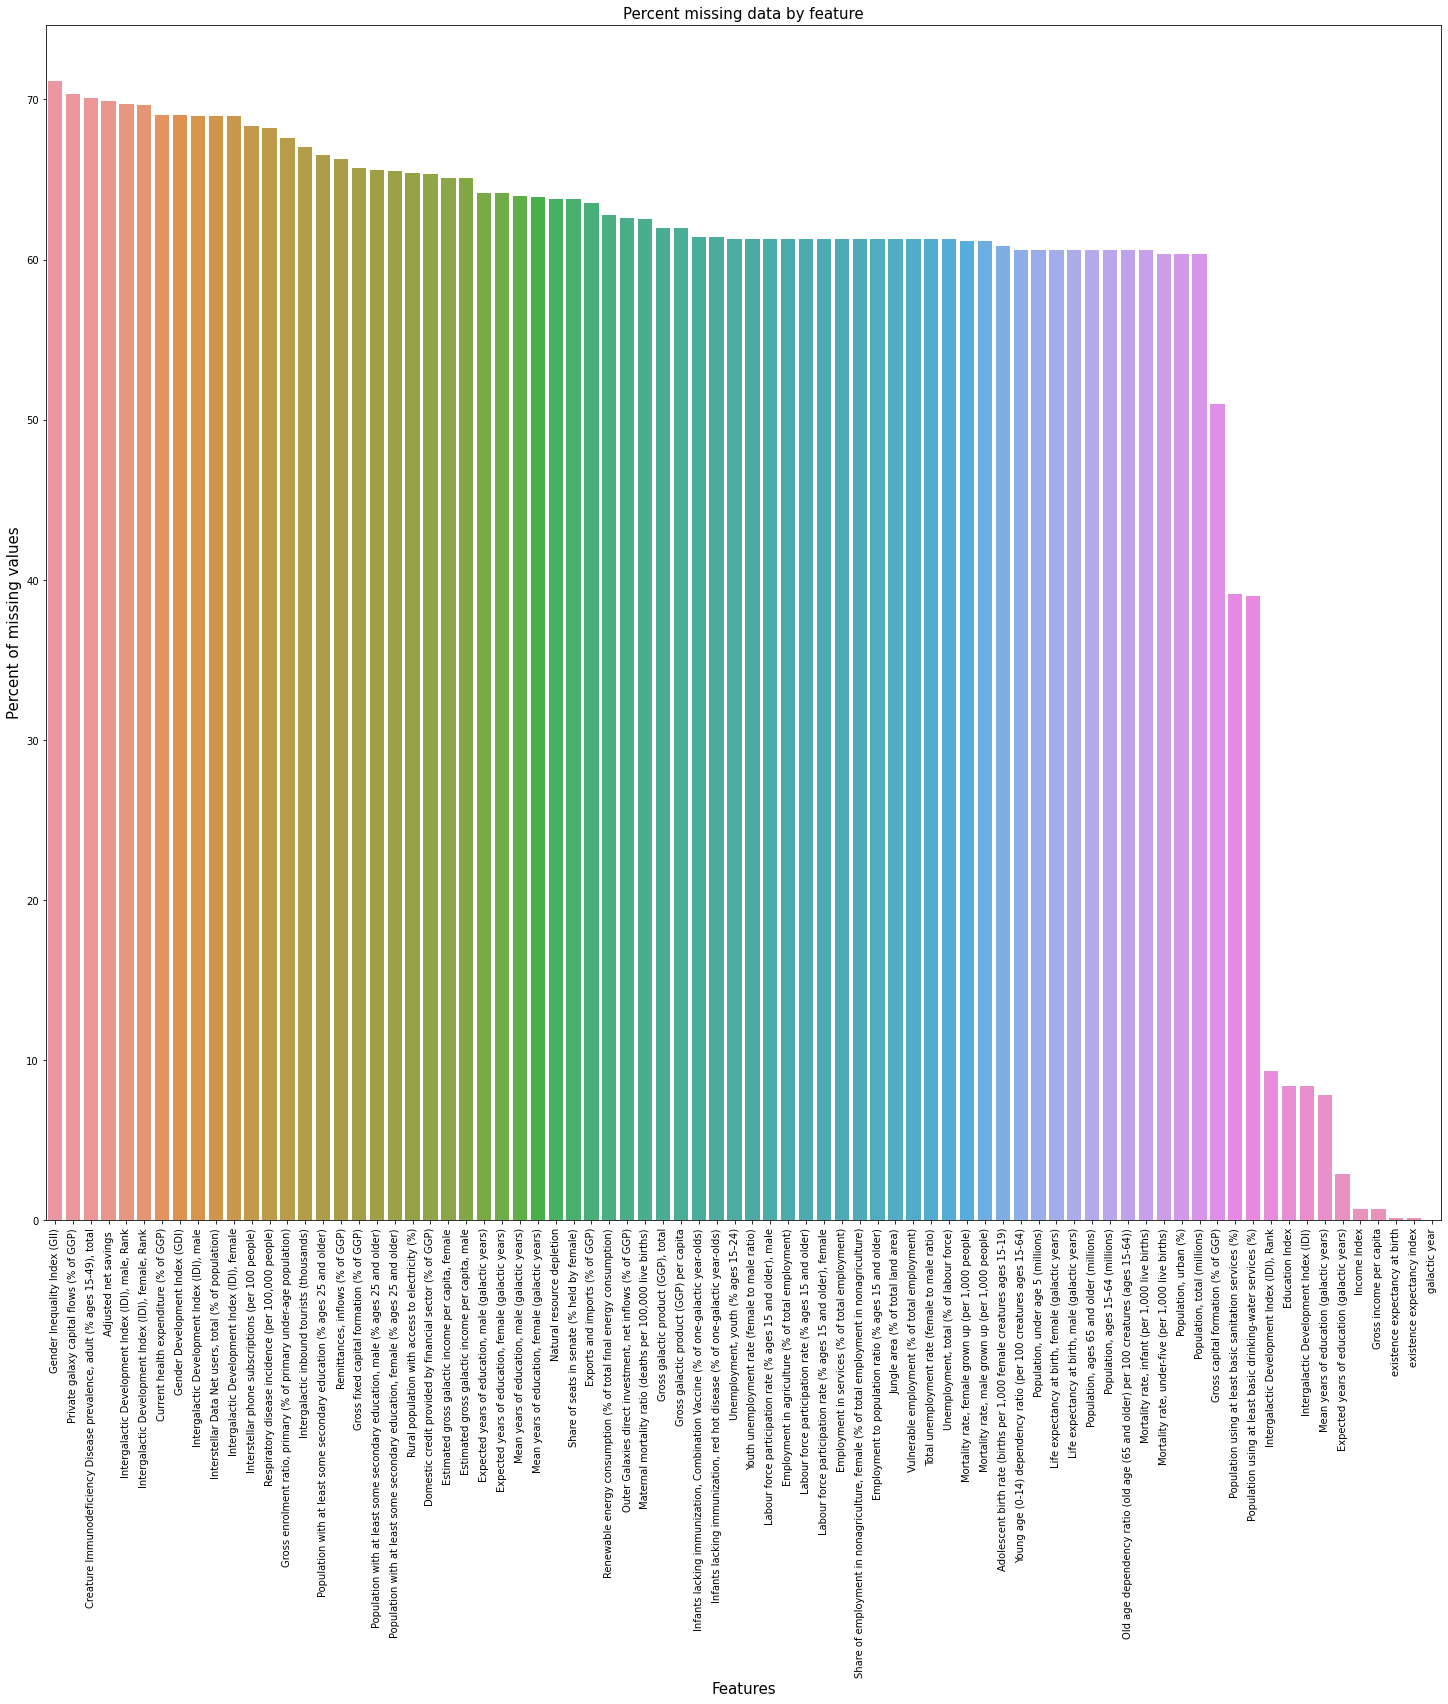

In [8]:
#percentages plot
f, ax = plt.subplots(figsize=(25, 22))
plt.xticks(rotation='90')
sns.barplot(x=null_per.index, y=null_per)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

This dataset is just messed up maaaan. so sad

In [9]:
#columns with null values < 60%
for entry, column in zip(null_perc.iloc[:, 0], null_perc.index):
    if entry <= 60:
        print(column)

Gross capital formation (% of GGP)
Population using at least basic sanitation services (%)
Population using at least basic drinking-water services (%)
Intergalactic Development Index (IDI), Rank
Education Index
Intergalactic Development Index (IDI)
Mean years of education (galactic years)
Expected years of education (galactic years)
Income Index
Gross income per capita
existence expectancy at birth
existence expectancy index
galactic year


### The latter

* GGP - Simple Imputer based on mean
* Population using at least basic sanitation services (%) - Simple Imputer based on mean
* Population using at least basic drinking-water services (%) - SimpleImputer based on mean
* Intergalactic Development Index (IDI), Rank - SimpleImputer based on most_frequent
* Intergalactic Development Index (IDI) - SimpleImputer based on mean
* Education Index -  SimpleImputer based on mean
* Mean years of education (galactic years) -  SimpleImputer based on mean
* Expected years of education (galactic years) -  SimpleImputer based on mean
* Income Index -  SimpleImputer based on mean
* Gross income per capita -  SimpleImputer based on mean
* existence expectancy at birth - SimpleImputer based on mean
* existence expectancy index-  SimpleImputer based on mean

In [10]:
features.columns

Index(['galactic year', 'existence expectancy index',
       'existence expectancy at birth', 'Gross income per capita',
       'Income Index', 'Expected years of education (galactic years)',
       'Mean years of education (galactic years)',
       'Intergalactic Development Index (IDI)', 'Education Index',
       'Intergalactic Development Index (IDI), Rank',
       'Population using at least basic drinking-water services (%)',
       'Population using at least basic sanitation services (%)',
       'Gross capital formation (% of GGP)', 'Population, total (millions)',
       'Population, urban (%)',
       'Mortality rate, under-five (per 1,000 live births)',
       'Mortality rate, infant (per 1,000 live births)',
       'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
       'Population, ages 15–64 (millions)',
       'Population, ages 65 and older (millions)',
       'Life expectancy at birth, male (galactic years)',
       'Life expectancy at bi

In [11]:
#imputing with column means.
columns = [1,2,3,4,5,6,7,8,10,11,12]
for col in columns:
    x = features.iloc[:, col].values
    x = x.reshape(-1,1)
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = imputer.fit(x)
    x = imputer.transform(x)
    features.iloc[:, col] = x    

In [12]:
#imputing 'Intergalactic Development Index (IDI), Rank' with most_frequent.
x = features.iloc[:, 9].values
x = x.reshape(-1,1)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x)
x = imputer.transform(x)
features.iloc[:, 9] = x    

In [13]:
x = features.iloc[:, 3].values
x = x.reshape(-1,1)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x)
x = imputer.transform(x)
features.iloc[:, 3] = x    

In [14]:
#Null numerical values (percentage)
null = features[numerical_cols].isna().sum().sort_values(ascending = False)
null_perc = (null/4755) * 100
null_perc = pd.DataFrame(null_perc)
null_perc.tail(15)         

,0
"Population, urban (%)",60.336488
"Population, total (millions)",60.336488
Mean years of education (galactic years),0.000000
existence expectancy index,0.000000
existence expectancy at birth,0.000000
Gross income per capita,0.000000
Income Index,0.000000
Expected years of education (galactic years),0.000000
Gross capital formation (% of GGP),0.000000
Intergalactic Development Index (IDI),0.000000


### The former (>60%)

In [15]:
features_to_be_dropped = []
for feature in features.columns:
    null_perc = null_perc
    for entry, column in zip(null_perc.iloc[:, 0], null_perc.index):
        if entry > 60:
            over_60 = column
            features_to_be_dropped.append(over_60)
            
print('\nFeatures with null values over 60%:\n')
print(features_to_be_dropped)

features = features.drop(features_to_be_dropped, axis=1).copy()
features.shape


Features with null values over 60%:

['Gender Inequality Index (GII)', 'Private galaxy capital flows (% of GGP)', 'Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total', 'Adjusted net savings ', 'Intergalactic Development Index (IDI), male, Rank', 'Intergalactic Development Index (IDI), female, Rank', 'Current health expenditure (% of GGP)', 'Gender Development Index (GDI)', 'Intergalactic Development Index (IDI), male', 'Interstellar Data Net users, total (% of population)', 'Intergalactic Development Index (IDI), female', 'Interstellar phone subscriptions (per 100 people)', 'Respiratory disease incidence (per 100,000 people)', 'Gross enrolment ratio, primary (% of primary under-age population)', 'Intergalactic inbound tourists (thousands)', 'Population with at least some secondary education (% ages 25 and older)', 'Remittances, inflows (% of GGP)', 'Gross fixed capital formation (% of GGP)', 'Population with at least some secondary education, male (% ages 25 and

(4755, 14)

In [16]:
features.head()

,galactic year,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),galaxy
0,990025,0.628657,63.125200,27109.234310,0.646039,8.240543,10.474162,0.812625,0.757174,137.612279,102.309904,100.424321,38.305483,Large Magellanic Cloud (LMC)
1,990025,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,152.522198,102.309904,100.424321,36.255559,Camelopardalis B
2,990025,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,209.813266,102.309904,100.424321,18.093991,Virgo I
3,990025,0.555862,52.333293,32012.256318,0.831098,14.975240,10.474162,0.812625,0.757174,137.612279,102.309904,100.424321,32.325739,UGC 8651 (DDO 181)
4,990025,0.991196,81.802464,81033.956906,1.131163,13.800672,13.188907,0.910341,0.918353,71.885345,102.309904,100.424321,34.497468,Tucana Dwarf


In [17]:
features.isna().any()

galactic year                                                  False
existence expectancy index                                     False
existence expectancy at birth                                  False
Gross income per capita                                        False
Income Index                                                   False
Expected years of education (galactic years)                   False
Mean years of education (galactic years)                       False
Intergalactic Development Index (IDI)                          False
Education Index                                                False
Intergalactic Development Index (IDI), Rank                    False
Population using at least basic drinking-water services (%)    False
Population using at least basic sanitation services (%)        False
Gross capital formation (% of GGP)                             False
galaxy                                                         False
dtype: bool

### Categorical Features

There's only one categorical features, **galaxy**, which is more like **ID**. I'm gonna drop it then work with the remaining 14 numerical columns.

In [18]:
features = features.drop(['galaxy'], axis = 1)
features.columns

Index(['galactic year', 'existence expectancy index',
       'existence expectancy at birth', 'Gross income per capita',
       'Income Index', 'Expected years of education (galactic years)',
       'Mean years of education (galactic years)',
       'Intergalactic Development Index (IDI)', 'Education Index',
       'Intergalactic Development Index (IDI), Rank',
       'Population using at least basic drinking-water services (%)',
       'Population using at least basic sanitation services (%)',
       'Gross capital formation (% of GGP)'],
      dtype='object')

### Feature Generation
* existence_expectancy_trend - based on 'existence expectancy index', 'existence expectancy at birth'
* pop using at least basic needs - based on drinking water services and sanitation services
* capital formation : per capita - based on capital formation and gross income per capita


In [19]:
features['existence_expectancy_trend '] = features['existence expectancy at birth'] / features['existence expectancy index']
features['access to basic needs'] = (features['Population using at least basic drinking-water services (%)'] + features['Population using at least basic sanitation services (%)']) / 2
features['capital formation to per capita'] = (features['Gross capital formation (% of GGP)'] * 100) / features['Gross income per capita']

### Distribution test and Skewness


 mu = 0.08 and sigma = 0.06



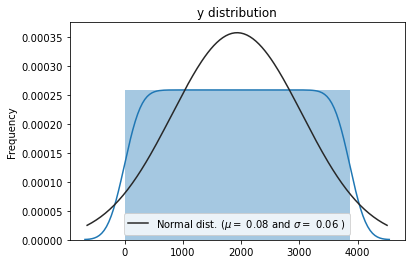

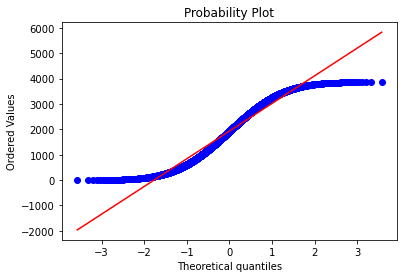

In [20]:
# Target variable
sns.distplot(train_dependent.index , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_dependent)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_dependent.index, plot=plt)
plt.show()

Linear models love normally distributed data but the plot shows that the variable is more **uniformly** distributed than **normally**. I tried applying boxcox and log transformations to normalize it but both miu and sigma were reducing when the latter should approach 1. So I'm gonna leave it as it is and comment out the code for the transformations.

In [21]:
# #We use the numpy fuction log1p which  applies log(1+x) to all elements of the column

#log transformation
# train_dependent = np.log1p(train_dependent)

#boxcox transformation.
# train_dependent = boxcox1p(train_dependent, boxcox_normmax(train_dependent + 1))

# #Check the new distribution 
# sns.distplot(train_dependent.index , fit=norm);

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train_dependent)
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# #Now plot the distribution
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.ylabel('Frequency')
# plt.title('SalePrice distribution')

# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(train_dependent.index, plot=plt)
# plt.show()

In [22]:
features.columns

Index(['galactic year', 'existence expectancy index',
       'existence expectancy at birth', 'Gross income per capita',
       'Income Index', 'Expected years of education (galactic years)',
       'Mean years of education (galactic years)',
       'Intergalactic Development Index (IDI)', 'Education Index',
       'Intergalactic Development Index (IDI), Rank',
       'Population using at least basic drinking-water services (%)',
       'Population using at least basic sanitation services (%)',
       'Gross capital formation (% of GGP)', 'existence_expectancy_trend ',
       'access to basic needs', 'capital formation to per capita'],
      dtype='object')

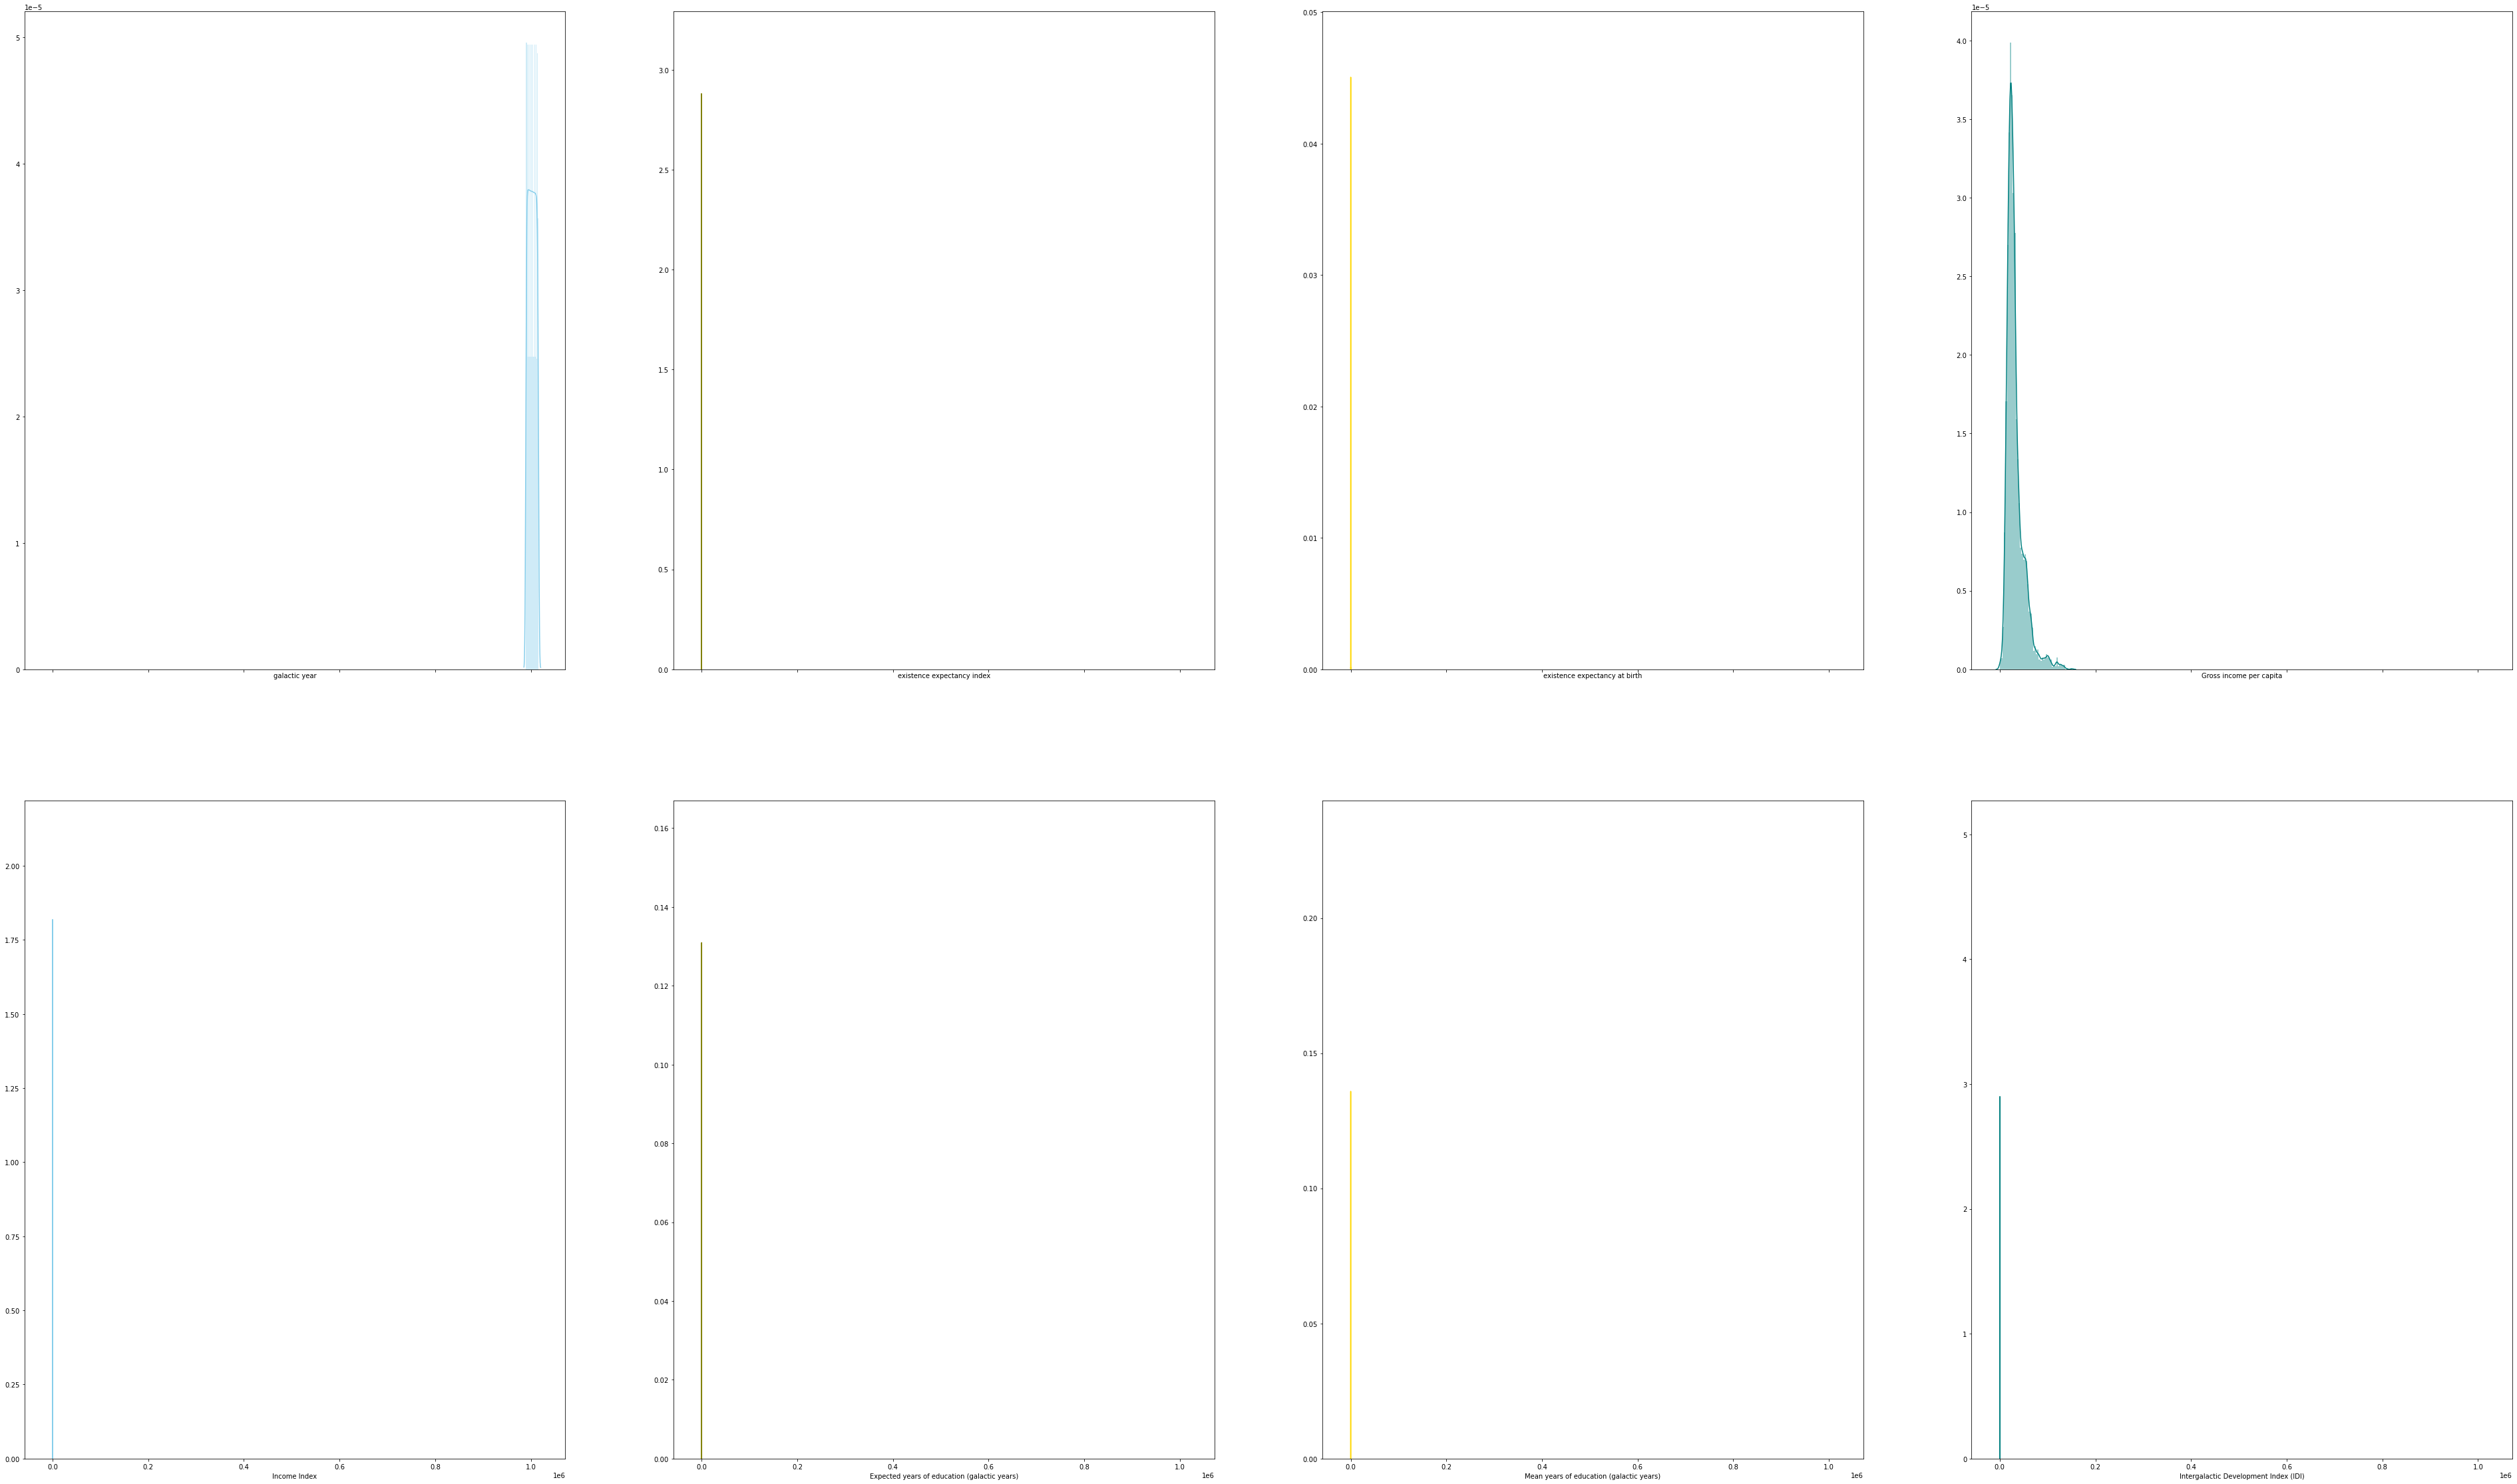

In [23]:
f, axes = plt.subplots(2, 4, figsize=(67, 40), sharex=True)
sns.distplot( features["galactic year"] , color="skyblue", ax=axes[0, 0])
sns.distplot( features["existence expectancy index"] , color="olive", ax=axes[0, 1])
sns.distplot( features["existence expectancy at birth"] , color="gold", ax=axes[0, 2])
sns.distplot( features["Gross income per capita"] , color="teal", ax=axes[0, 3])
sns.distplot( features["Income Index"] , color="skyblue", ax=axes[1, 0])
sns.distplot( features["Expected years of education (galactic years)"] , color="olive", ax=axes[1, 1])
sns.distplot( features["Mean years of education (galactic years)"] , color="gold", ax=axes[1, 2])
sns.distplot( features["Intergalactic Development Index (IDI)"] , color="teal", ax=axes[1, 3])

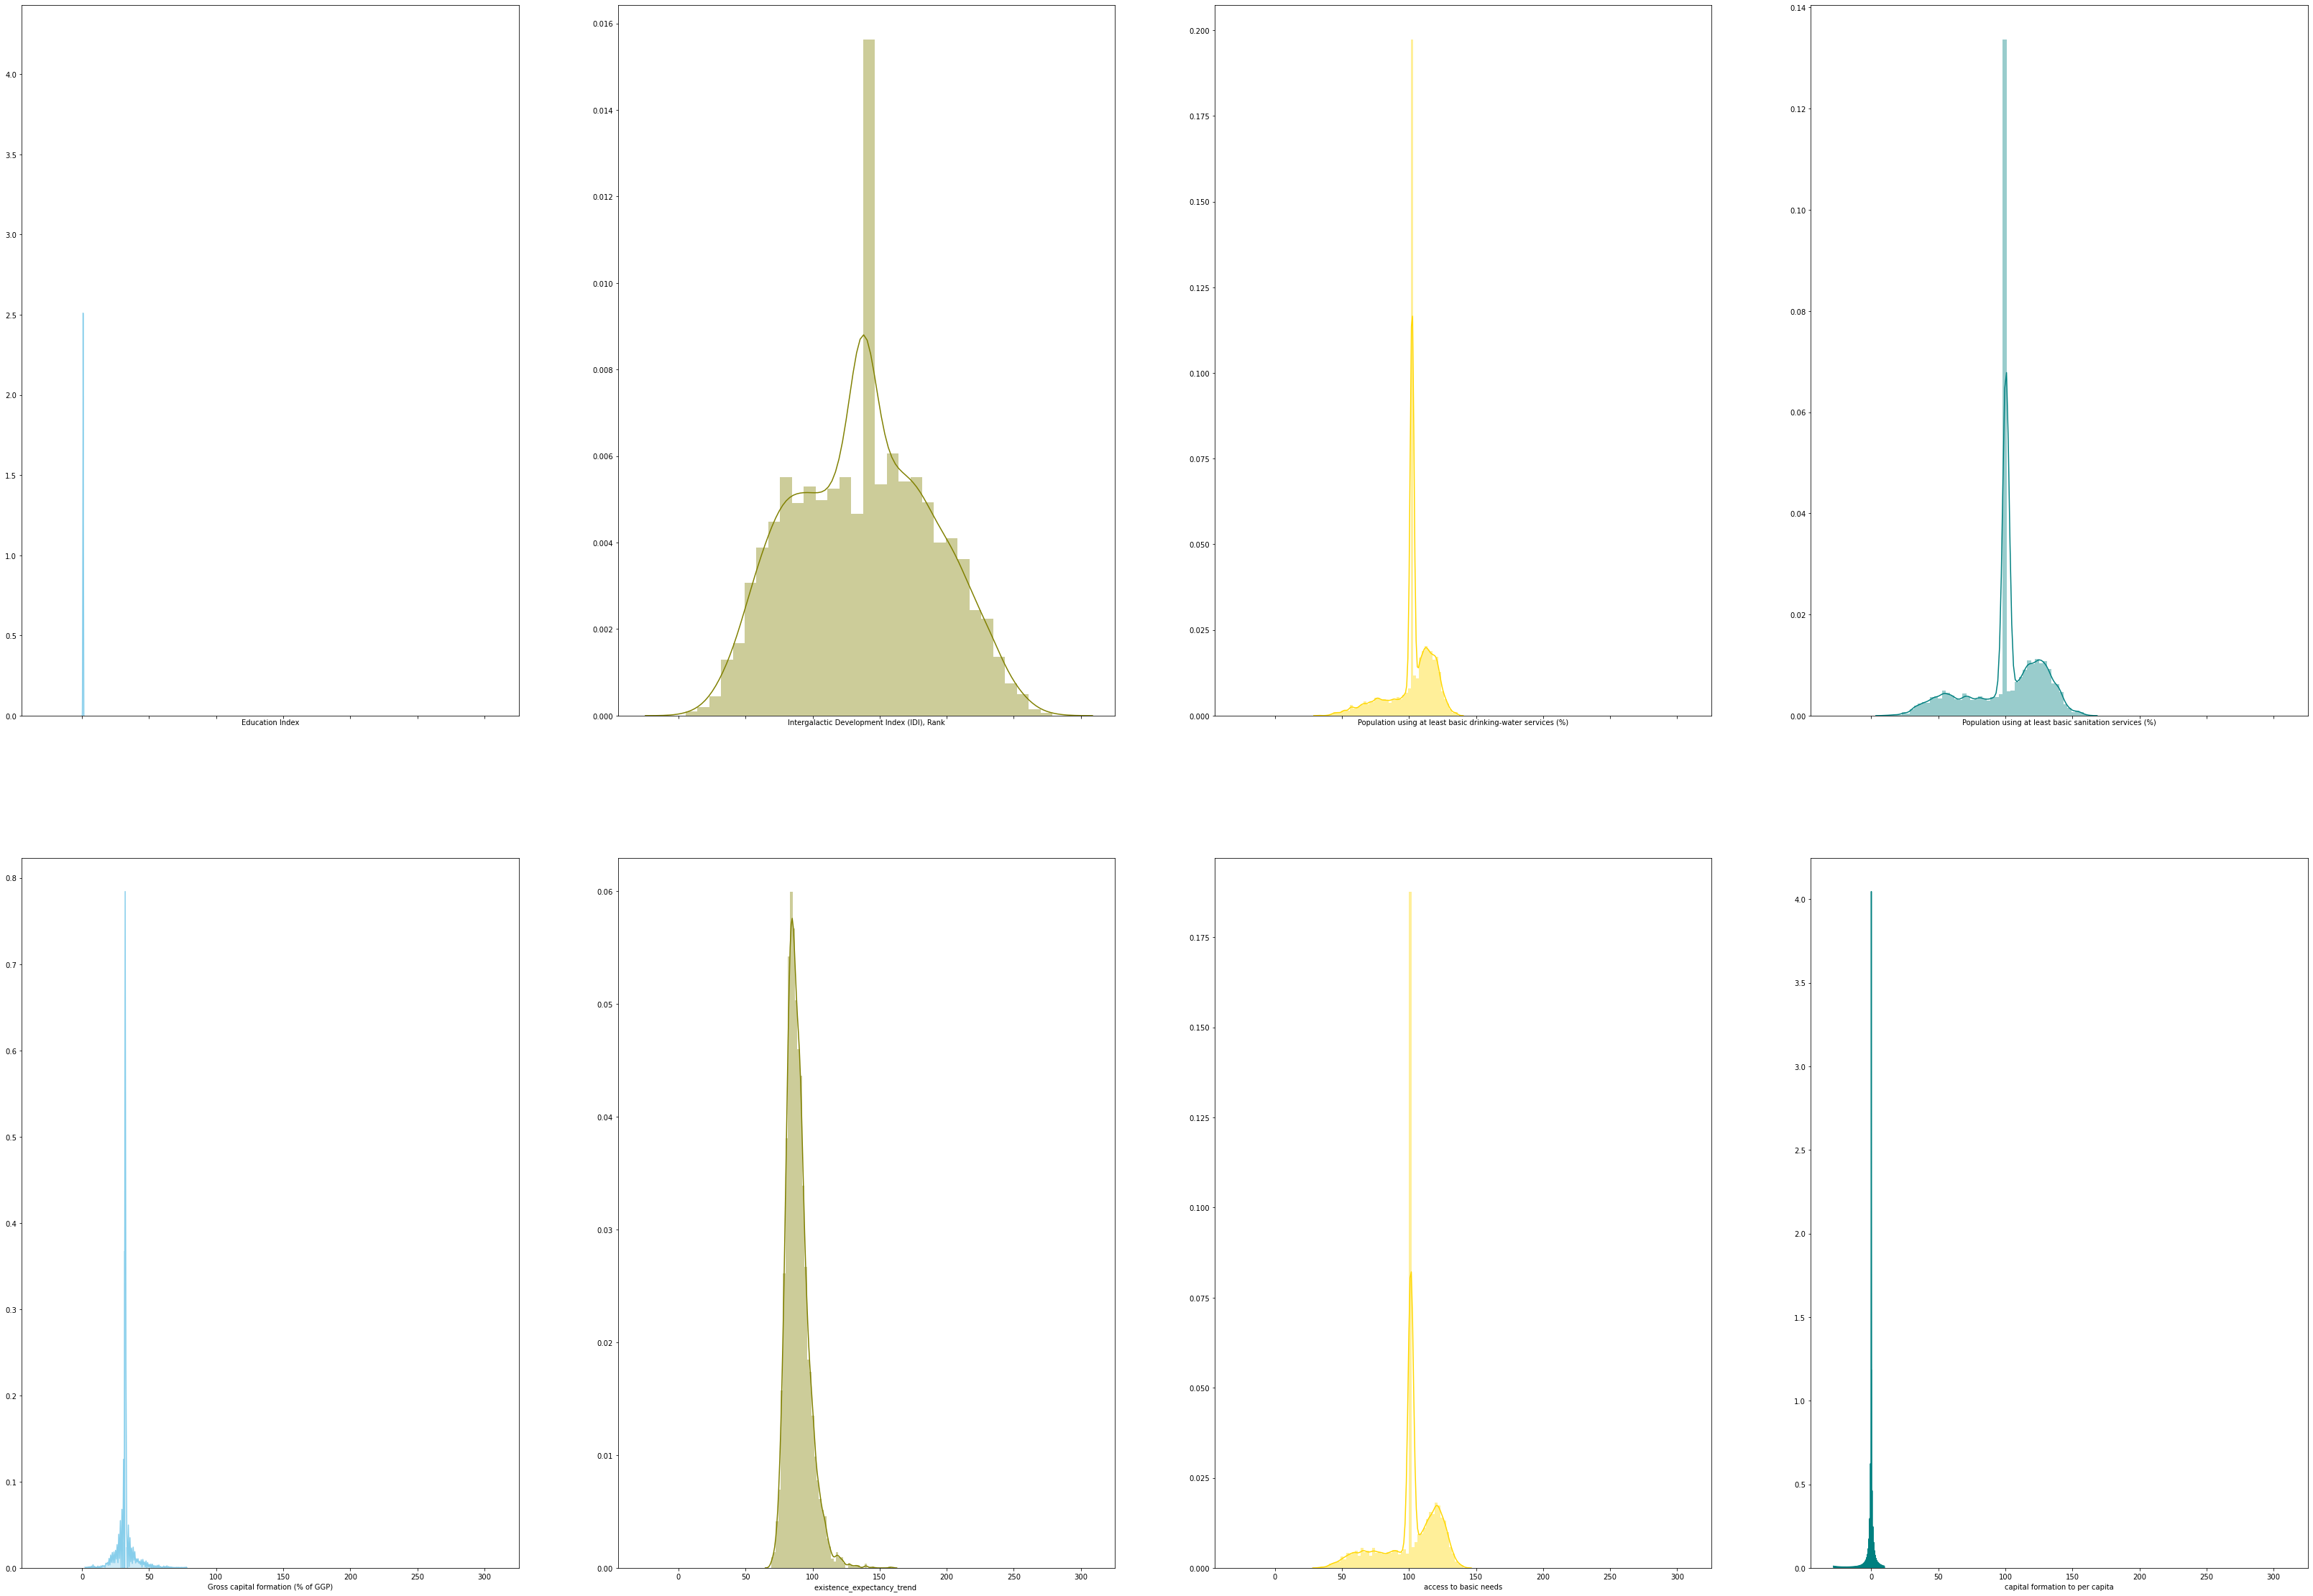

In [24]:
f, axes = plt.subplots(2, 4, figsize=(57, 40), sharex=True)
sns.distplot( features["Education Index"] , color="skyblue", ax=axes[0, 0])
sns.distplot( features["Intergalactic Development Index (IDI), Rank"] , color="olive", ax=axes[0, 1])
sns.distplot( features["Population using at least basic drinking-water services (%)"] , color="gold", ax=axes[0, 2])
sns.distplot( features["Population using at least basic sanitation services (%)"] , color="teal", ax=axes[0, 3])
sns.distplot( features["Gross capital formation (% of GGP)"] , color="skyblue", ax=axes[1, 0])
sns.distplot( features["existence_expectancy_trend "] , color="olive", ax=axes[1, 1])
sns.distplot( features["access to basic needs"] , color="gold", ax=axes[1, 2])
sns.distplot( features["capital formation to per capita"] , color="teal", ax=axes[1, 3])

In [25]:
# numerical variables
norm_features = ['galactic year','Gross income per capita',
       'Intergalactic Development Index (IDI), Rank',
       'Population using at least basic drinking-water services (%)',
       'Population using at least basic sanitation services (%)',
       'Gross capital formation (% of GGP)', 'existence_expectancy_trend ',
       'access to basic needs', 'capital formation to per capita']
skew_features = features[norm_features].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

low_skew = skew_features[skew_features < -0.5]
low_skew_index = low_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})

print("There are {} numerical features with Skew < -0.5 :".format(low_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :low_skew})
skew_features

There are 3 numerical features with Skew > 0.5 :
There are 4 numerical features with Skew < -0.5 :


Gross income per capita                                         2.069697
existence_expectancy_trend                                      1.319472
Gross capital formation (% of GGP)                              0.956814
Intergalactic Development Index (IDI), Rank                     0.058974
galactic year                                                   0.011099
Population using at least basic sanitation services (%)        -0.746326
access to basic needs                                          -0.938154
Population using at least basic drinking-water services (%)    -1.238537
capital formation to per capita                               -39.645910
dtype: float64

In [26]:
print(skew_index)

Index(['Gross income per capita', 'existence_expectancy_trend ',
       'Gross capital formation (% of GGP)'],
      dtype='object')


In [27]:
# # Normalize skewed features with boxcox transformation
# for i in skew_index:
#     features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
# for j in low_skew_index:
#     features[j] = boxcox1p(features[j], boxcox_normmax(features[j] + 1))
for i in skew_index:
    log_max = np.log(features[i].max())
    features[i] = features[i]**(1/log_max)

In [28]:
for i in low_skew_index:
    log_max = np.log(features[i].max())
    features[i] = features[i]**(1/log_max)

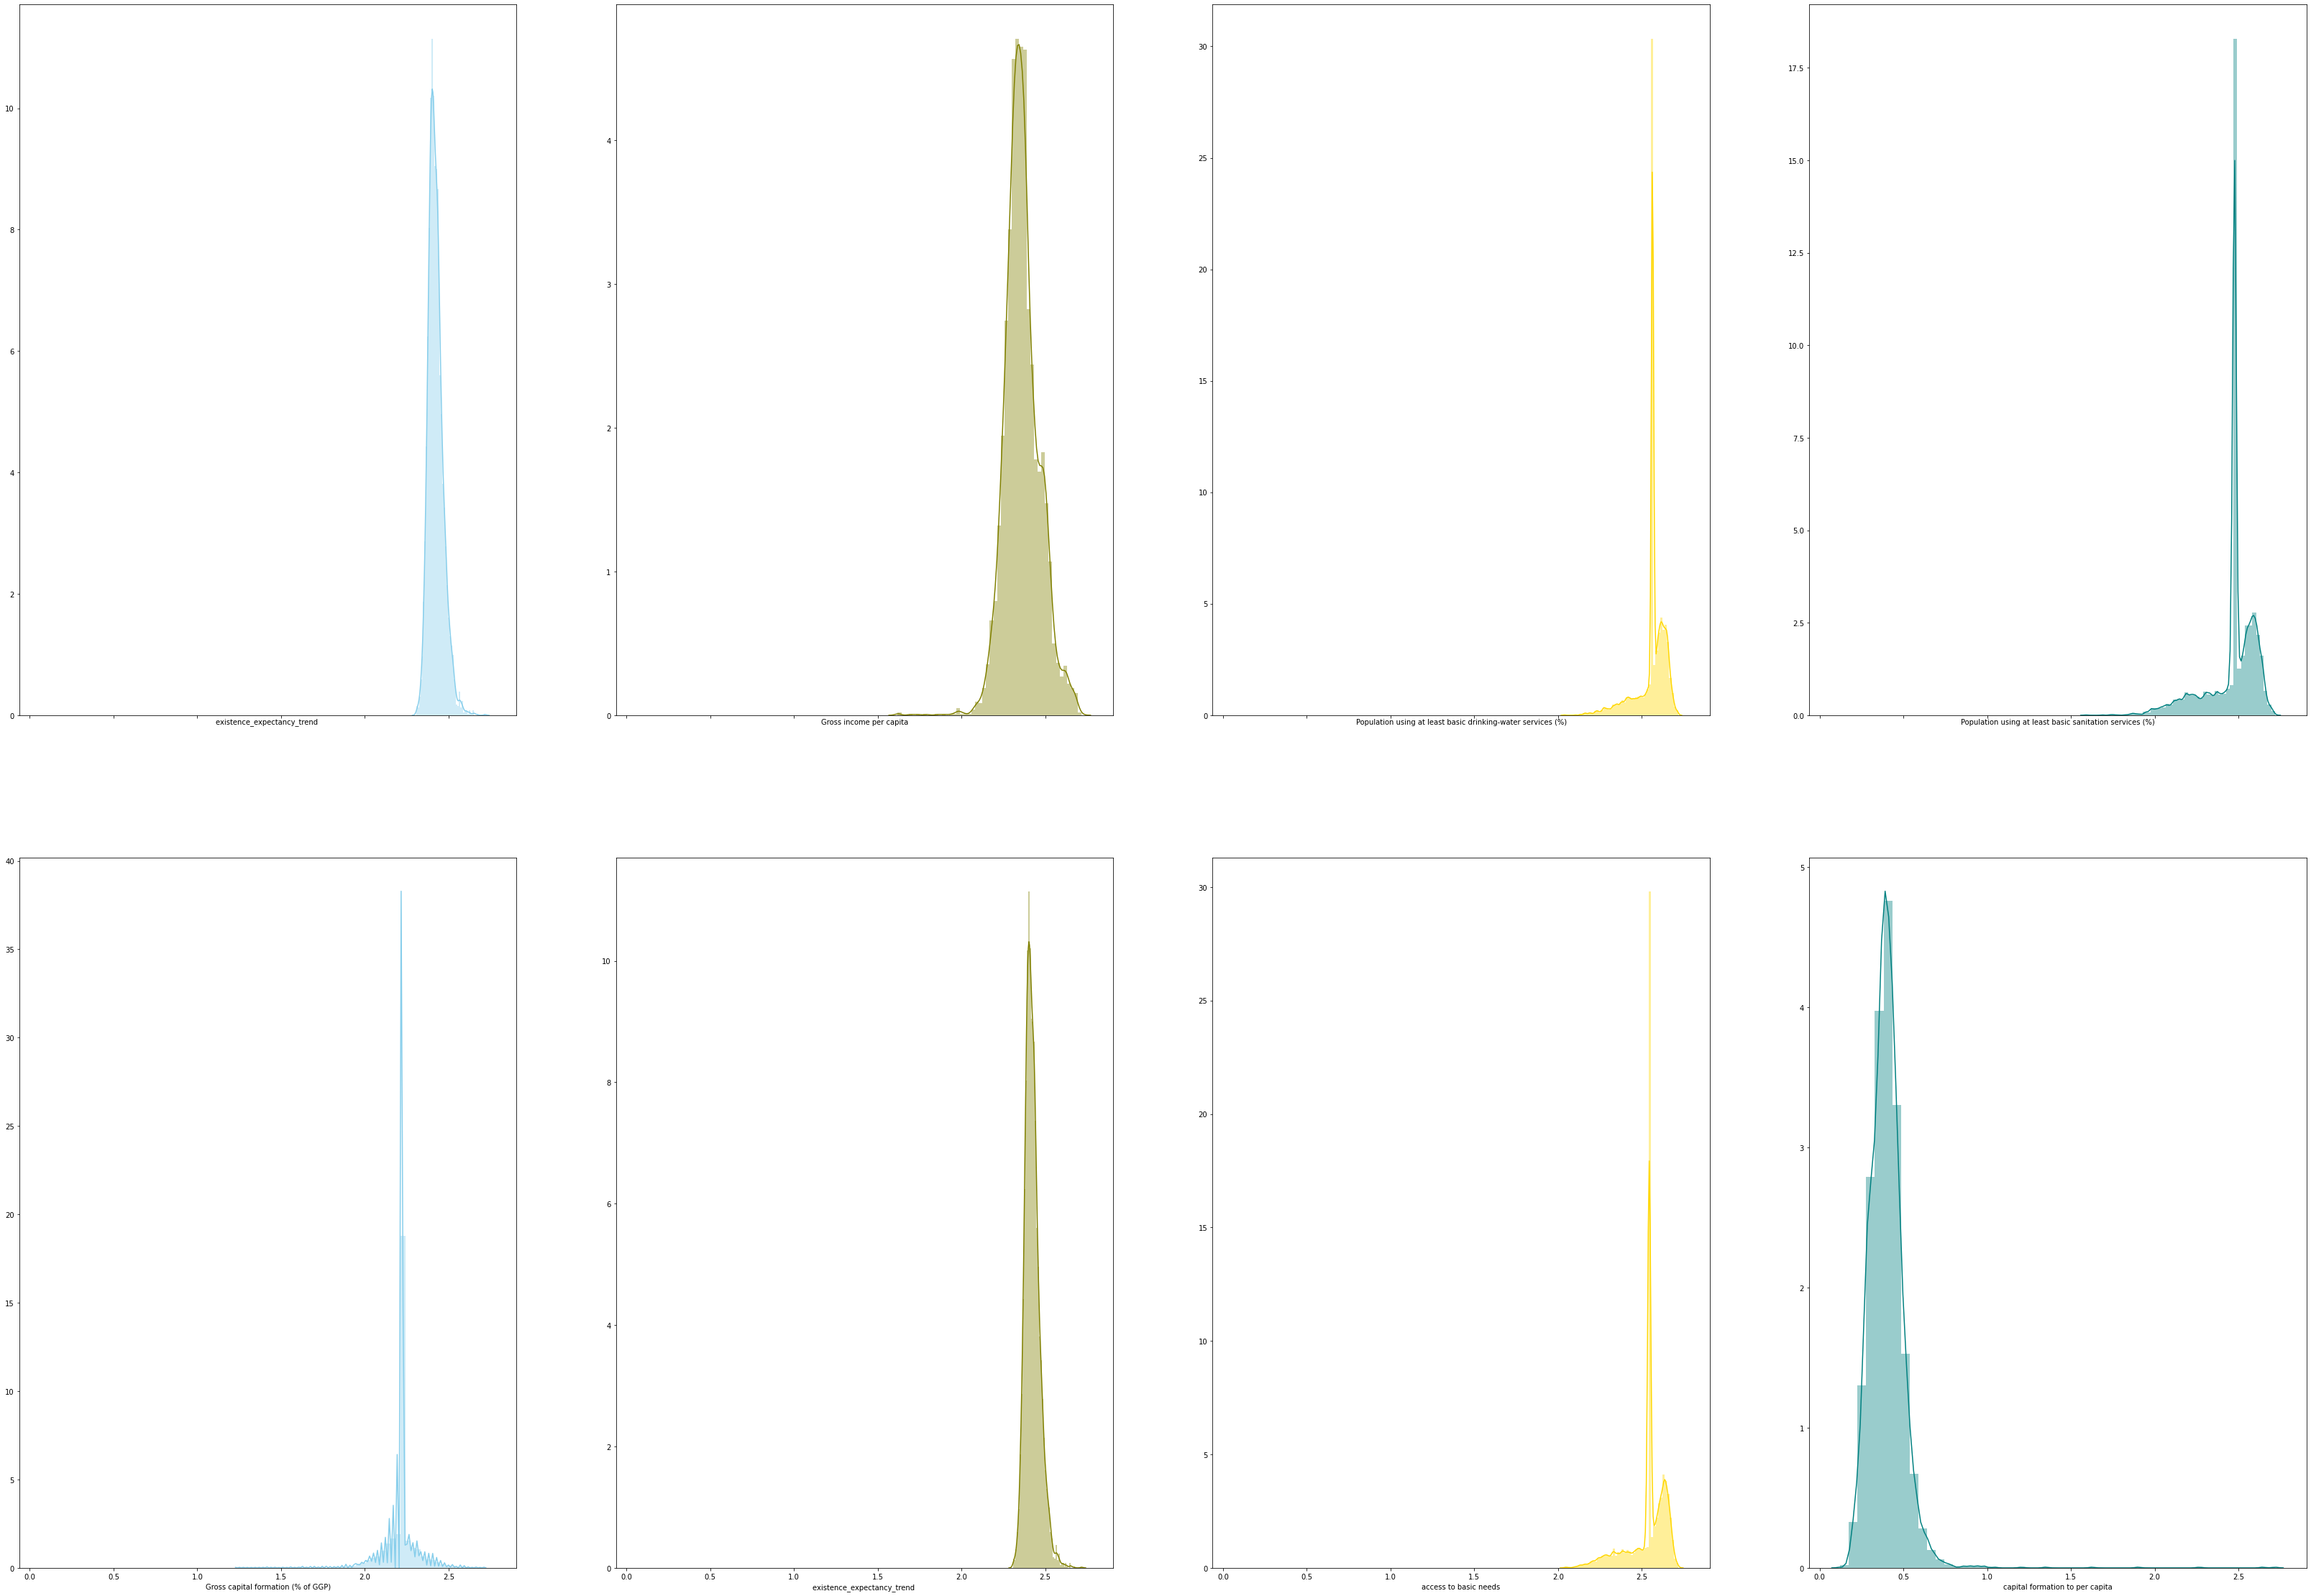

In [29]:
f, axes = plt.subplots(2, 4, figsize=(57, 40), sharex=True)
sns.distplot( features["existence_expectancy_trend "] , color="skyblue", ax=axes[0, 0])
sns.distplot( features["Gross income per capita"] , color="olive", ax=axes[0, 1])
sns.distplot( features["Population using at least basic drinking-water services (%)"] , color="gold", ax=axes[0, 2])
sns.distplot( features["Population using at least basic sanitation services (%)"] , color="teal", ax=axes[0, 3])
sns.distplot( features["Gross capital formation (% of GGP)"] , color="skyblue", ax=axes[1, 0])
sns.distplot( features["existence_expectancy_trend "] , color="olive", ax=axes[1, 1])
sns.distplot( features["access to basic needs"] , color="gold", ax=axes[1, 2])
sns.distplot( features["capital formation to per capita"] , color="teal", ax=axes[1, 3])

In [30]:
# skewness after
norm_features = ['galactic year','Gross income per capita',
       'Intergalactic Development Index (IDI), Rank',
       'Population using at least basic drinking-water services (%)',
       'Population using at least basic sanitation services (%)',
       'Gross capital formation (% of GGP)', 'existence_expectancy_trend ',
       'access to basic needs', 'capital formation to per capita']
skews = features[norm_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skews

existence_expectancy_trend                                     0.941041
Intergalactic Development Index (IDI), Rank                    0.058974
galactic year                                                  0.011099
Gross capital formation (% of GGP)                            -1.249165
access to basic needs                                         -1.471144
Population using at least basic sanitation services (%)       -1.561788
Population using at least basic drinking-water services (%)   -1.807245
Gross income per capita                                             NaN
capital formation to per capita                                     NaN
dtype: float64

good enough. 

### Multicolinearity

In [31]:
#defining numerical features again to include the added features for the correlation plot to be plotted.
numerical_cols= []
for column in train_features.columns:
    if train_features[column].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical_cols.append(column)

new_train_set = pd.concat([features.iloc[:len(train_dependent), :], train_dependent], axis=1)

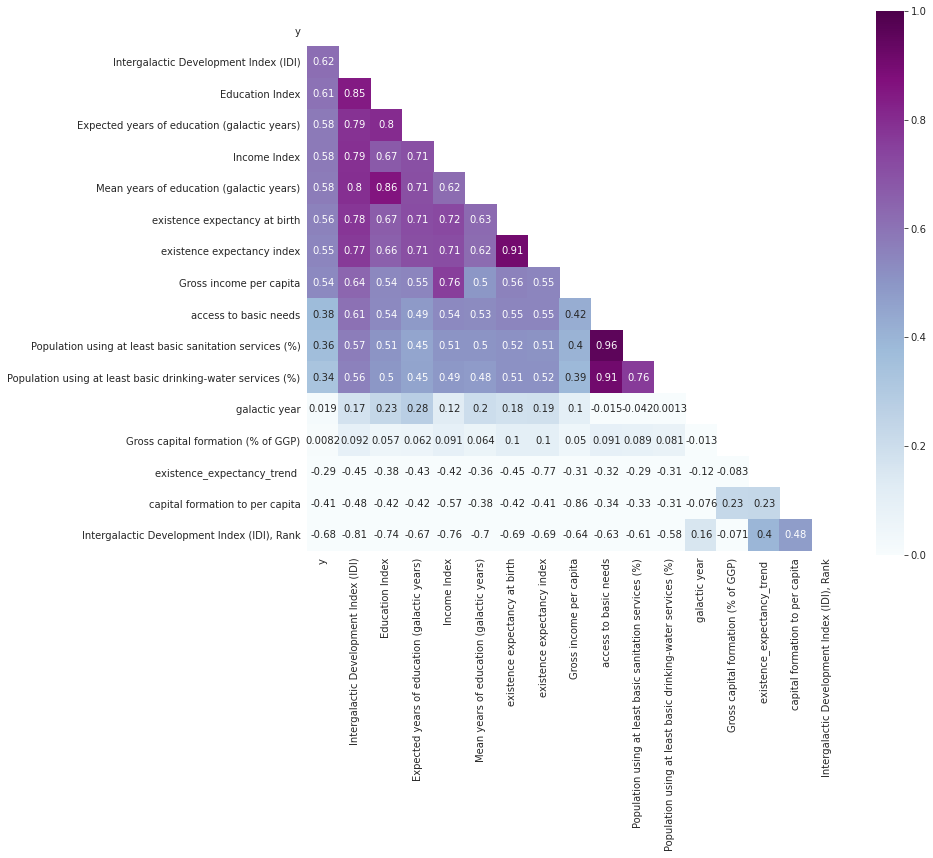

In [32]:
def correlation_map(f_data, f_feature, f_number):
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(12, 10))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=1, square=True,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()

correlation_map(new_train_set, 'y', 20)

basic needs, sanitation and water: high corrrelation.
basic needs has a higher in relation to y, so I'm gonna drop sanitation and water.

In [33]:
features = features.drop(['Population using at least basic drinking-water services (%)', 'Population using at least basic sanitation services (%)'], axis = 1)

### Outliers

credits to [this kernel on outlier detection using chauvenets creterion](http://kaggle.com/nroman/detecting-outliers-with-chauvenet-s-criterion)

In [34]:
def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = erfc(d)                # Area normal dist.    
    return prob < criterion       # Use boolean array outside this function

In [35]:
features_outliers = dict()
for col in [col for col in features.columns if 'var_' in col]:
    features_outliers[col] = features[chauvenet(train[col].values)].shape[0]
features_outliers = pd.Series(features_outliers)
features_outliers

Series([], dtype: float64)

It's an empty series, meaning we're safe on the outliers side.
We can check that visually using scatterplots.

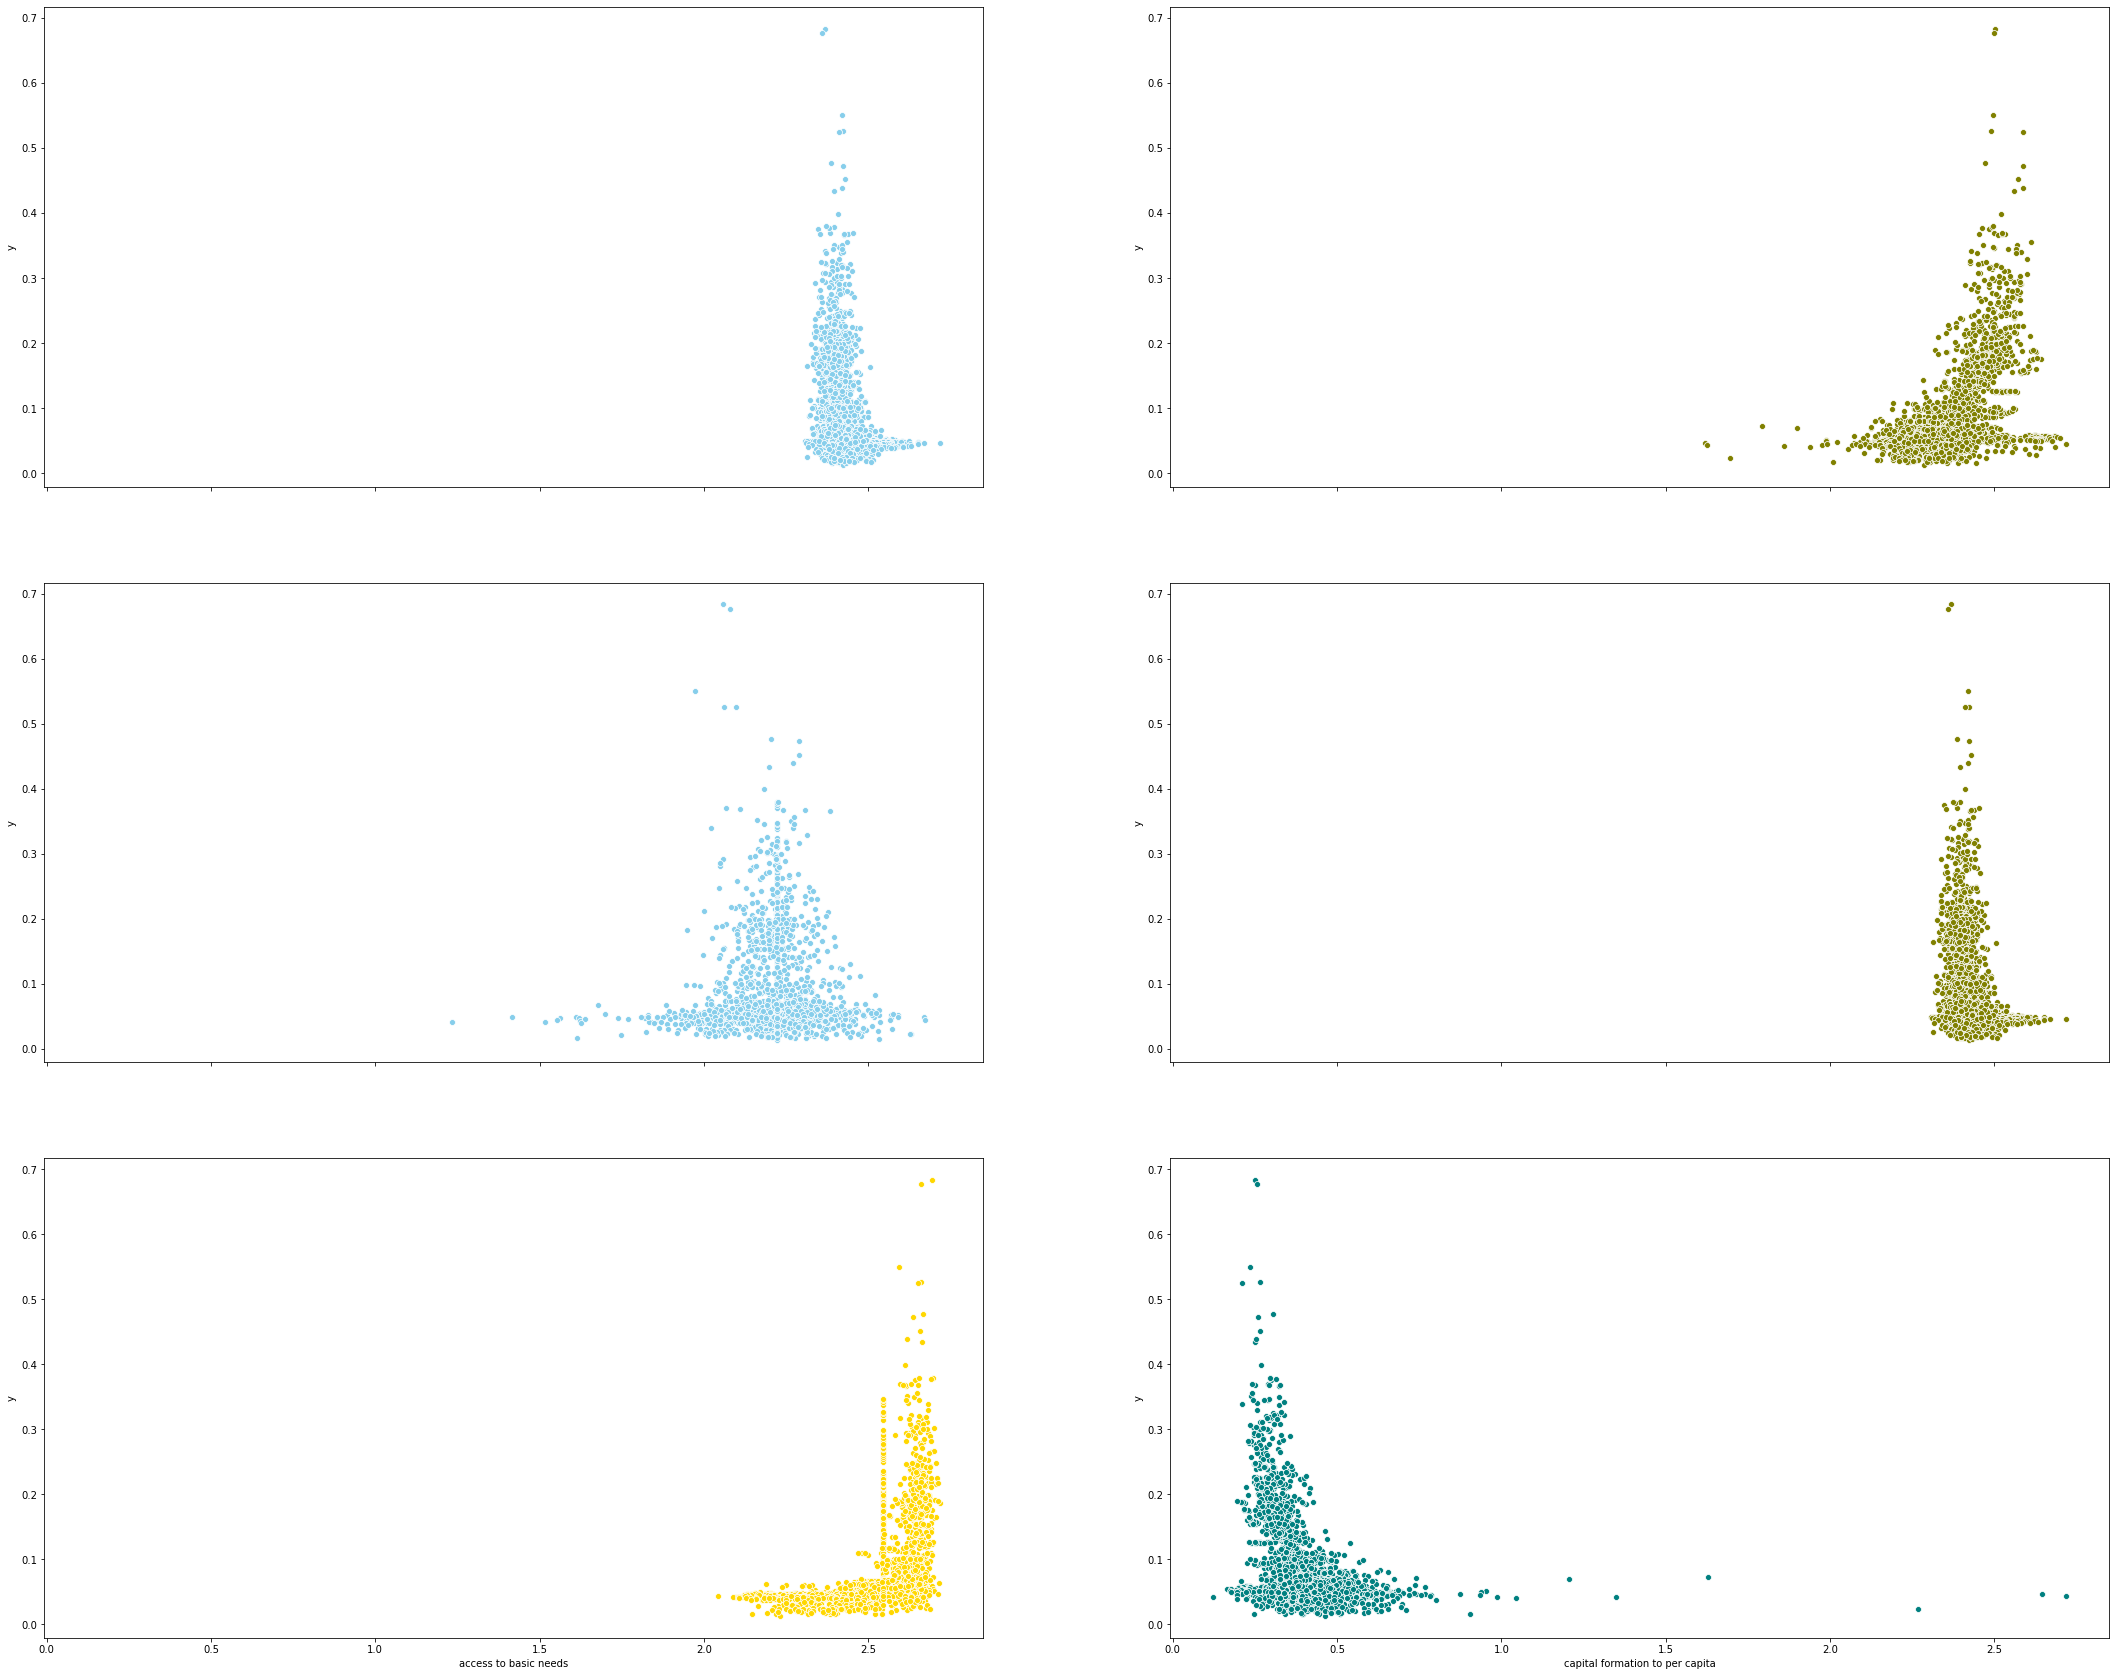

In [36]:
f, axes = plt.subplots(3, 2, figsize=(37, 30), sharex=True)
sns.scatterplot(x = new_train_set["existence_expectancy_trend "] ,y = new_train_set['y'], color="skyblue", ax=axes[0, 0])
sns.scatterplot(x = new_train_set["Gross income per capita"] ,y = new_train_set['y'], color="olive", ax=axes[0, 1])
sns.scatterplot(x = new_train_set["Gross capital formation (% of GGP)"] ,y = new_train_set['y'], color="skyblue", ax=axes[1, 0])
sns.scatterplot(x = new_train_set["existence_expectancy_trend "] ,y = new_train_set['y'], color="olive", ax=axes[1, 1])
sns.scatterplot(x = new_train_set["access to basic needs"] ,y = new_train_set['y'], color="gold", ax=axes[2, 0])
sns.scatterplot(x = new_train_set["capital formation to per capita"] ,y = new_train_set['y'], color="teal", ax=axes[2, 1])


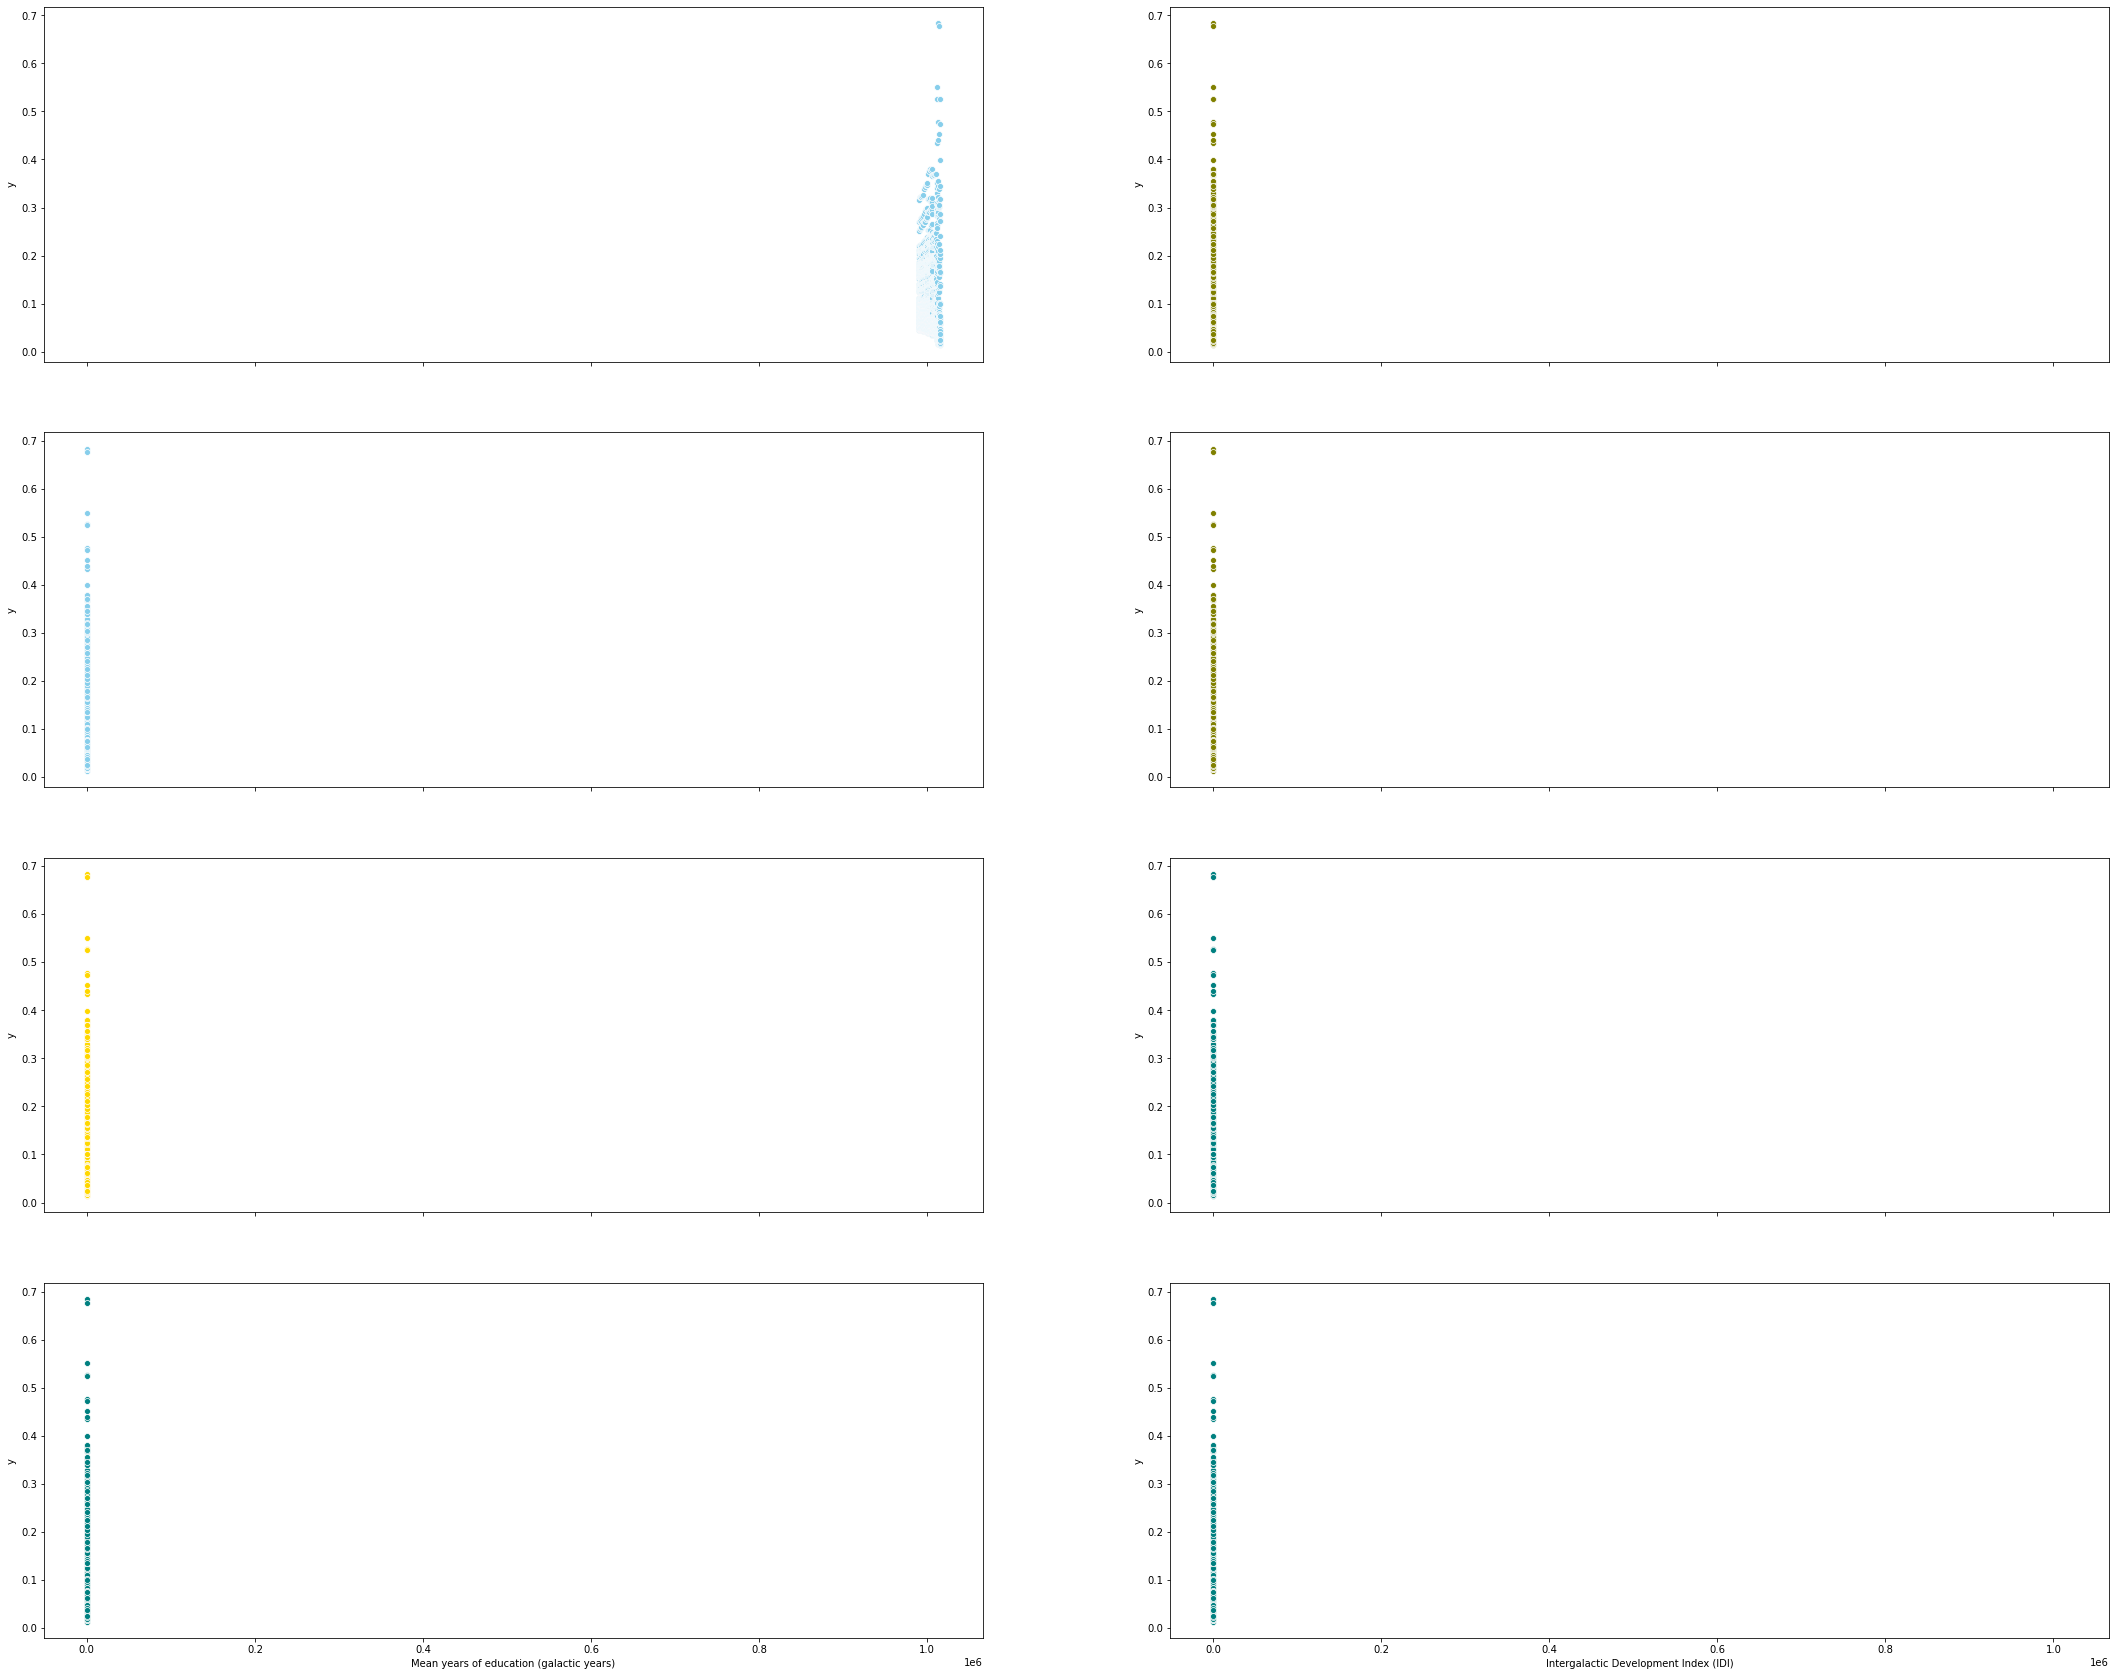

In [37]:
f, axes = plt.subplots(4, 2, figsize=(37, 30), sharex=True)
sns.scatterplot(x = new_train_set["galactic year"] ,y = new_train_set['y'], color="skyblue", ax=axes[0, 0])
sns.scatterplot(x = new_train_set["existence expectancy index"] ,y = new_train_set['y'], color="olive", ax=axes[0, 1])
sns.scatterplot(x = new_train_set["existence expectancy at birth"] ,y = new_train_set['y'], color="skyblue", ax=axes[1, 0])
sns.scatterplot(x = new_train_set["Gross income per capita"] ,y = new_train_set['y'], color="olive", ax=axes[1, 1])
sns.scatterplot(x = new_train_set["Income Index"] ,y = new_train_set['y'], color="gold", ax=axes[2, 0])
sns.scatterplot(x = new_train_set["Expected years of education (galactic years)"] ,y = new_train_set['y'], color="teal", ax=axes[2, 1])
sns.scatterplot(x = new_train_set["Mean years of education (galactic years)"] ,y = new_train_set['y'], color="teal", ax=axes[3, 0])
sns.scatterplot(x = new_train_set["Intergalactic Development Index (IDI)"] ,y = new_train_set['y'], color="teal", ax=axes[3, 1])

Capital formation doesn't look good. Solving that using percentiles but applying to all columns.

In [38]:
#Capping the outlier rows with Percentiles
cols = features.columns
for col in cols:
    upper_lim = features[col].quantile(.95)
    lower_lim = features[col].quantile(.05)
    features.loc[(features[col] > upper_lim),col] = upper_lim
    features.loc[(features[col] < lower_lim),col] = lower_lim
    
print(features.shape)

(4755, 14)


In [39]:
features.dtypes

galactic year                                   float64
existence expectancy index                      float64
existence expectancy at birth                   float64
Gross income per capita                         float64
Income Index                                    float64
Expected years of education (galactic years)    float64
Mean years of education (galactic years)        float64
Intergalactic Development Index (IDI)           float64
Education Index                                 float64
Intergalactic Development Index (IDI), Rank     float64
Gross capital formation (% of GGP)              float64
existence_expectancy_trend                      float64
access to basic needs                           float64
capital formation to per capita                 float64
dtype: object

There's no categorical features to encode, thus we skip that.

### Reconstruct train and test sets

In [40]:
x_train = features.iloc[:len(train_dependent), :]
x_test = features.iloc[len(train_dependent):, :]
y_train = train_dependent
train_set = pd.concat([x_train, y_train], axis=1)

print('x train', x_train.shape)
print('y train', y_train.shape)
print('train set', train_set.shape)
print('x test', x_test.shape)

x train (3865, 14)
y train (3865,)
train set (3865, 15)
x test (890, 14)


Imputing forgotten nans. Not done in the most efficient order but gets the job done.

In [41]:
x = x_train.iloc[:, 3].values
x = x.reshape(-1,1)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x)
x = imputer.transform(x)
x_train.iloc[:, 3] = x    

In [42]:
x = x_train.iloc[:, -1].values
x = x.reshape(-1,1)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x)
x = imputer.transform(x)
x_train.iloc[:, -1] = x    

## Modelling.

Credits to this awesome [kernel](http://kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook#Modelling)

In [43]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [44]:
#lasso regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=0))

#elastic net regression
enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=1))

#lightgbm
lgb = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

#gradboost
gdb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

#kernelridge
kr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#xgboost
xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

### Model scores

In [45]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0432 (0.0123)



In [46]:
score = rmsle_cv(enet)
print("\nElastic net score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Elastic net score: 0.0431 (0.0123)



In [47]:
score = rmsle_cv(lgb)
print("\nlightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


lightgbm score: 0.0310 (0.0110)



In [48]:
score = rmsle_cv(gdb)
print("\ngradboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


gradboost score: 0.0310 (0.0103)



In [49]:
score = rmsle_cv(kr)
print("\nkernel ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


kernel ridge score: 0.0432 (0.0121)



In [50]:
score = rmsle_cv(xgb)
print("\nxgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[07:27:38] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:27:43] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:27:47] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Viewing the performances using a barplot

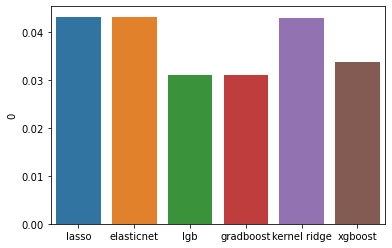

In [51]:
l = [0.0432, 0.0431, 0.0310, 0.0310, 0.0430, 0.0337]
c = ['lasso', 'elasticnet', 'lgb', 'gradboost', 'kernel ridge', 'xgboost']
# data = {'lasso': [0.0432], 'elasticnet': [0.0431], 'lgb': [0.0310], 'gradboost': [0.0310], 'kernel ridge': [0.0430], 'xgboost':  [0.0337]}
df = pd.DataFrame(l, index = c)
sns.barplot(x = df.index, y = df[0])


### Stacking

In [52]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, x_train, y_train):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(x_train, y_train)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, x_train):
        predictions = np.column_stack([
            model.predict(x_train) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [53]:
#averaging models and observing score change.
averaged_models = AveragingModels(models = (lasso, enet, lgb, xgb, gdb))

In [54]:
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[07:28:01] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:28:28] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:28:55] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


score better than 3 of the models

### Averaging w/a meta model trained with predictions of base models under kfold

In [55]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

performance

In [56]:
stacked_averaged_models = StackingAveragedModels(base_models = (xgb, gdb, averaged_models),
                                                 meta_model = lgb)

# score = rmsle_cv(stacked_averaged_models)
# print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

### Final fitting and prediction

In [57]:
# evaluation
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [58]:
# stacked model
stacked_averaged_models.fit(x_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(x_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(x_test.values))
print(rmsle(y_train, stacked_train_pred))

[07:30:14] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:30:18] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:30:22] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


scored better than the models and the averaged model too.

In [59]:
#gradboost
gdb.fit(x_train, y_train)
gdb_train_pred = gdb.predict(x_train)
gdb_pred = np.expm1(gdb.predict(x_test))
print(rmsle(y_train, gdb_train_pred))

0.015215194899359909


In [60]:
# xgb
xgb.fit(x_train, y_train)
xgb_train_pred = xgb.predict(x_train)
xgb_pred = np.expm1(xgb.predict(x_test))
print(rmsle(y_train, xgb_train_pred))

[07:35:08] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.030173101327980283


In [61]:
# lgb
lgb.fit(x_train.values, y_train)
lgb_train_pred = lgb.predict(x_train)
lgb_pred = np.expm1(lgb.predict(x_test.values))
print(rmsle(y_train, lgb_train_pred))

0.021534161176007767


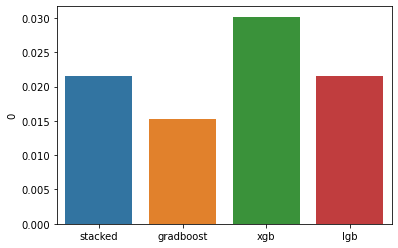

In [62]:
l = [0.021496434619159566, 0.015215194899359909, 0.030173101327980283, 0.021534161176007767
]
c = ['stacked', 'gradboost', 'xgb', 'lgb']
df = pd.DataFrame(l, index = c)
sns.barplot(x = df.index, y = df[0])

ditch xgboost

In [63]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.05 +
               gdb_train_pred*0.9 + lgb_train_pred*0.05))

RMSLE score on train data:
0.015416142962874857


In [64]:
ensemble = stacked_pred*0.05 + gdb_pred*0.90 + lgb_pred*0.05

In [65]:
ensemble.shape

(890,)

### Submission

In [66]:
submission.shape

(890, 3)

In [67]:
submission = submission
index = list(submission.index)
pred = list(ensemble)
file = pd.DataFrame({'index':index, 'pred': pred})
submission = file.set_index('index')
submission.to_csv('sub.csv')

In [68]:
submission.head(3)

,pred
index,
0,0.043774
1,0.039017
2,0.041280


## Energy allocation headache

In [69]:
!pip install pulp

     |████████████████████████████████| 40.6 MB 56.8 MB/s eta 0:00:01


##### First let B  = Budget = 50,000
Then let Ei = Energy allocation i
Then let c = (1/1000) * (Index increase potential) ^ 2

So, now you want to maximize SUM( c x E )

By using these variable names I'm trying to clarify and separate the constants from the variable. E in this case is the optimization variable, while c is a constant basically. This is one of the reasons why it is a Linear programming problem. Otherwise, it could be convex, convex quadratic, non-convex problems, and so on.

The optimizer would assign values to E such that the maximum possible value of F = SUM(c x E) would be attained. F is known as the objective function, in other parlance; cost function or loss.


I am not yet at the constraint, there are more or less 3 steps to an optimization process. Translate problem, define objective function, define constraints, then run solver.

The optimizer would assign values to E such that the maximum possible value of F = SUM(c x E) would be attained. F is known as the objective function, in other parlance; cost function or loss.


For the constraints, the first is that B = 50,000. So all the energies assigned to the galaxies (that means SUM( Ei )) has to be less than 50,000.


For the constraints, the first is that B = 50,000. So all the energies assigned to the galaxies (that means SUM( Ei )) has to be at most 50,000.  

The next constrain is that energy for each galaxy (that means Ei ) has to be between 0 and 100.

So constraint 2 is 0 <= Ei <= 100

The third constraint requires more nuance. One way to do it is to inject a binary variable (b). So b is where eei of galaxy i is less than 0.7. You can do it with python. It will return True and False values. Then simply add 0 (+0) to the outcome, and an automatic type coercion will change the T/F to 1/0. You then multiply this with the galaxies, to get the ones with eei < 0.7. Once this is done, the constraint becomes SUM(Ei (of b)) <= 10% x B.


Alternatively, you could split it into two optimization problems since it is LP, One with the galaxies where eei > 0.7, and B = 45,000 and another one with galaxies eei < 0.7 and B = 5000. Then combine your predictions.

You can have a look at PuLP or Scipy.optimize

The challenge here is that your predictions y determine your objective function F. So if those are wrong, your optimization would be wrong too. It'll be quite wrong because LP will assign that maximum possible ie 100 to the galaxies and 0 to others. This is a case of uncertain data, there are many research articles on this subject, you might want to look at stochastic optimization or robust LP. Nonetheless, I don't think the challenge requires something that advanced. You can think of a way to overcome this problem. This is my trick; use different models to predict y, then for each model's prediction of y, perform the optimization. Then you take the average. This means that, you are less likely to have just 0s and 100s in your opt energies (edited) 

### Using ensemble predictions

In [70]:
x_test['y_pred'] = pred
x_test['potential for increase'] = -np.log(x_test['y_pred'] + .01) + 3
y = x_test['potential for increase']
y.head()

0    5.922970
1    6.015584
2    5.970462
3    6.067579
4    6.410238
Name: potential for increase, dtype: float64

In [71]:
#creating the new column indicating <0.7 and >= in the eei
x_test['condition_1_for_true'] = np.where(x_test['existence expectancy index'] < 0.7, 1, 0)

* E is the optimisation variable.(Energy allocation)
* Ei is the energy allocation per galaxy.
* c is a constant.
* b is the eei condition column
* B is the total energy available

In [139]:
# b = x_test[x_test['condition_1_for_true'] == 1]
b = x_test['condition_1_for_true']
c = (1/1000) * (y ** 2)
c.head(3)

0    0.035523
1    0.036385
2    0.035723
Name: potential for increase stacked_pred, dtype: float64

Text(0.5, 0, '1 for galaxies with eei < 0.7')

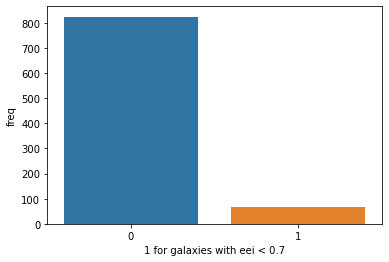

In [132]:
sns.countplot(b)
plt.ylabel('freq')
plt.xlabel('1 for galaxies with eei < 0.7')

In [133]:
b.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [134]:
import pulp as p 
  
# Create a LP Minimization problem 
prob = p.LpProblem('Problem', p.LpMaximize)  

# Create problem Variables 
variables = []
n = range(0,np.size(b),1)
for i in n:
    variables.append(i)

# B = p.LpVariable("B", lowBound = 0)  
E = p.LpVariable.dicts("E", variables, lowBound = 0, upBound = 100)

# Objective Function 
prob += p.lpSum(p.lpDot(E.values(), c))
# prob += np.sum(c * E.values())  #objective is to maximise the sum of the column.

# Constraints:   
# prob += B == 50000
prob += p.lpSum(E.values()) <= 50000
prob += p.lpSum(p.lpDot(E.values(), b.values)) == 5000

# # Display the problem 
print(prob) 

status = prob.solve()   # Solver 
print(p.LpStatus[status])   # The solution status 

# Printing the final solution 
print(p.value(B), p.value(prob.objective))  

Problem:
MAXIMIZE
0.03552306318375998*E_0 + 0.03638521126085961*E_1 + 0.035722952194604564*E_10 + 0.0354497786510383*E_100 + 0.03564476955474832*E_101 + 0.040494575480803194*E_102 + 0.035722952194604564*E_103 + 0.03462083637616715*E_104 + 0.0354497786510383*E_105 + 0.040494575480803194*E_106 + 0.040494575480803194*E_107 + 0.038037878388603334*E_108 + 0.0363058088023164*E_109 + 0.04061075863584652*E_11 + 0.0363058088023164*E_110 + 0.040494575480803194*E_111 + 0.04061075863584652*E_112 + 0.0354497786510383*E_113 + 0.0354497786510383*E_114 + 0.040494575480803194*E_115 + 0.0354497786510383*E_116 + 0.03638521126085961*E_117 + 0.0381354531882735*E_118 + 0.040494575480803194*E_119 + 0.035722952194604564*E_12 + 0.040494575480803194*E_120 + 0.035722952194604564*E_121 + 0.0381354531882735*E_122 + 0.040494575480803194*E_123 + 0.0381354531882735*E_124 + 0.040494575480803194*E_125 + 0.04061075863584652*E_126 + 0.040494575480803194*E_127 + 0.038037878388603334*E_128 + 0.038037878388603334*E_129 + 0.

In [135]:
from pulp import value

def print_result(problem):
    print('Optimization status:', problem.status)
    print('Final value of the objective:', value(problem.objective))
    print('Final values of the variables:')
    for var in problem.variables():
        global x
        x = var, '=', value(var)
        print(x)
        
print_result(prob)

Optimization status: 1
Final value of the objective: 1803.1852979654755
Final values of the variables:
(E_0, '=', 0.0)
(E_1, '=', 100.0)
(E_10, '=', 0.0)
(E_100, '=', 100.0)
(E_101, '=', 100.0)
(E_102, '=', 100.0)
(E_103, '=', 100.0)
(E_104, '=', 100.0)
(E_105, '=', 100.0)
(E_106, '=', 100.0)
(E_107, '=', 100.0)
(E_108, '=', 100.0)
(E_109, '=', 100.0)
(E_11, '=', 100.0)
(E_110, '=', 100.0)
(E_111, '=', 100.0)
(E_112, '=', 100.0)
(E_113, '=', 100.0)
(E_114, '=', 100.0)
(E_115, '=', 100.0)
(E_116, '=', 100.0)
(E_117, '=', 100.0)
(E_118, '=', 100.0)
(E_119, '=', 100.0)
(E_12, '=', 0.0)
(E_120, '=', 100.0)
(E_121, '=', 100.0)
(E_122, '=', 100.0)
(E_123, '=', 100.0)
(E_124, '=', 100.0)
(E_125, '=', 100.0)
(E_126, '=', 100.0)
(E_127, '=', 100.0)
(E_128, '=', 100.0)
(E_129, '=', 100.0)
(E_13, '=', 100.0)
(E_130, '=', 100.0)
(E_131, '=', 100.0)
(E_132, '=', 100.0)
(E_133, '=', 100.0)
(E_134, '=', 100.0)
(E_135, '=', 100.0)
(E_136, '=', 100.0)
(E_137, '=', 100.0)
(E_138, '=', 100.0)
(E_139, '='

In [136]:
for var in prob.variables():
    global a
    a = var
# all(isinstance(a, str) for a in prob.variables())
    b = ((value(var)))
    print(a, '~' ,b)

E_0 ~ 0.0
E_1 ~ 100.0
E_10 ~ 0.0
E_100 ~ 100.0
E_101 ~ 100.0
E_102 ~ 100.0
E_103 ~ 100.0
E_104 ~ 100.0
E_105 ~ 100.0
E_106 ~ 100.0
E_107 ~ 100.0
E_108 ~ 100.0
E_109 ~ 100.0
E_11 ~ 100.0
E_110 ~ 100.0
E_111 ~ 100.0
E_112 ~ 100.0
E_113 ~ 100.0
E_114 ~ 100.0
E_115 ~ 100.0
E_116 ~ 100.0
E_117 ~ 100.0
E_118 ~ 100.0
E_119 ~ 100.0
E_12 ~ 0.0
E_120 ~ 100.0
E_121 ~ 100.0
E_122 ~ 100.0
E_123 ~ 100.0
E_124 ~ 100.0
E_125 ~ 100.0
E_126 ~ 100.0
E_127 ~ 100.0
E_128 ~ 100.0
E_129 ~ 100.0
E_13 ~ 100.0
E_130 ~ 100.0
E_131 ~ 100.0
E_132 ~ 100.0
E_133 ~ 100.0
E_134 ~ 100.0
E_135 ~ 100.0
E_136 ~ 100.0
E_137 ~ 100.0
E_138 ~ 100.0
E_139 ~ 100.0
E_14 ~ 100.0
E_140 ~ 100.0
E_141 ~ 100.0
E_142 ~ 100.0
E_143 ~ 100.0
E_144 ~ 100.0
E_145 ~ 100.0
E_146 ~ 100.0
E_147 ~ 100.0
E_148 ~ 100.0
E_149 ~ 100.0
E_15 ~ 100.0
E_150 ~ 100.0
E_151 ~ 0.0
E_152 ~ 100.0
E_153 ~ 100.0
E_154 ~ 100.0
E_155 ~ 100.0
E_156 ~ 100.0
E_157 ~ 100.0
E_158 ~ 100.0
E_159 ~ 100.0
E_16 ~ 100.0
E_160 ~ 100.0
E_161 ~ 100.0
E_162 ~ 100.0
E_163 ~ 100

E_74 ~ 100.0
E_740 ~ 0.0
E_741 ~ 0.0
E_742 ~ 100.0
E_743 ~ 0.0
E_744 ~ 0.0
E_745 ~ 0.0
E_746 ~ 0.0
E_747 ~ 0.0
E_748 ~ 0.0
E_749 ~ 0.0
E_75 ~ 100.0
E_750 ~ 0.0
E_751 ~ 0.0
E_752 ~ 0.0
E_753 ~ 100.0
E_754 ~ 100.0
E_755 ~ 0.0
E_756 ~ 0.0
E_757 ~ 0.0
E_758 ~ 0.0
E_759 ~ 0.0
E_76 ~ 100.0
E_760 ~ 0.0
E_761 ~ 0.0
E_762 ~ 0.0
E_763 ~ 0.0
E_764 ~ 0.0
E_765 ~ 0.0
E_766 ~ 100.0
E_767 ~ 0.0
E_768 ~ 0.0
E_769 ~ 0.0
E_77 ~ 100.0
E_770 ~ 0.0
E_771 ~ 0.0
E_772 ~ 0.0
E_773 ~ 0.0
E_774 ~ 0.0
E_775 ~ 100.0
E_776 ~ 0.0
E_777 ~ 0.0
E_778 ~ 0.0
E_779 ~ 0.0
E_78 ~ 100.0
E_780 ~ 0.0
E_781 ~ 0.0
E_782 ~ 0.0
E_783 ~ 0.0
E_784 ~ 0.0
E_785 ~ 0.0
E_786 ~ 0.0
E_787 ~ 0.0
E_788 ~ 0.0
E_789 ~ 0.0
E_79 ~ 100.0
E_790 ~ 100.0
E_791 ~ 0.0
E_792 ~ 0.0
E_793 ~ 100.0
E_794 ~ 0.0
E_795 ~ 0.0
E_796 ~ 0.0
E_797 ~ 0.0
E_798 ~ 0.0
E_799 ~ 0.0
E_8 ~ 0.0
E_80 ~ 100.0
E_800 ~ 0.0
E_801 ~ 0.0
E_802 ~ 0.0
E_803 ~ 0.0
E_804 ~ 0.0
E_805 ~ 0.0
E_806 ~ 0.0
E_807 ~ 0.0
E_808 ~ 0.0
E_809 ~ 0.0
E_81 ~ 100.0
E_810 ~ 0.0
E_811 ~ 0.0
E_812 ~ 

### Using stacked pred

In [140]:
x_test['stacked_pred'] = list(stacked_pred)
x_test['potential for increase stacked_pred'] = -np.log(x_test['stacked_pred'] + .01) + 3
y = x_test['potential for increase stacked_pred']
c = (1/1000) * (y ** 2)

import pulp as p 
from pulp import value

  
# Create a LP Minimization problem 
prob = p.LpProblem('Problem', p.LpMaximize)  

# Create problem Variables 
variables = []
n = range(0,np.size(b),1)
for i in n:
    variables.append(i)

# B = p.LpVariable("B", lowBound = 0)  
E = p.LpVariable.dicts("E", variables, lowBound = 0, upBound = 100)

# Objective Function 
prob += p.lpSum(p.lpDot(E.values(), c))
# prob += np.sum(c * E.values())  #objective is to maximise the sum of the column.

# Constraints: 
l = [100] * 890
    
# prob += B == 50000
prob += p.lpSum(E.values()) <= 50000
prob += p.lpSum(p.lpDot(E.values(), b.values)) == 5000

# # Display the problem 
print(prob) 

status = prob.solve()   # Solver 

def print_result(problem):
    print('Optimization status:', problem.status)
    print('Final value of the objective:', value(problem.objective))
    print('Final values of the variables:')
    for var in problem.variables():
        global y
        y = var, '=', value(var)
        print(y)
        
print_result(prob)

Problem:
MAXIMIZE
0.03552306318375998*E_0 + 0.03638521126085961*E_1 + 0.035722952194604564*E_10 + 0.0354497786510383*E_100 + 0.03564476955474832*E_101 + 0.040494575480803194*E_102 + 0.035722952194604564*E_103 + 0.03462083637616715*E_104 + 0.0354497786510383*E_105 + 0.040494575480803194*E_106 + 0.040494575480803194*E_107 + 0.038037878388603334*E_108 + 0.0363058088023164*E_109 + 0.04061075863584652*E_11 + 0.0363058088023164*E_110 + 0.040494575480803194*E_111 + 0.04061075863584652*E_112 + 0.0354497786510383*E_113 + 0.0354497786510383*E_114 + 0.040494575480803194*E_115 + 0.0354497786510383*E_116 + 0.03638521126085961*E_117 + 0.0381354531882735*E_118 + 0.040494575480803194*E_119 + 0.035722952194604564*E_12 + 0.040494575480803194*E_120 + 0.035722952194604564*E_121 + 0.0381354531882735*E_122 + 0.040494575480803194*E_123 + 0.0381354531882735*E_124 + 0.040494575480803194*E_125 + 0.04061075863584652*E_126 + 0.040494575480803194*E_127 + 0.038037878388603334*E_128 + 0.038037878388603334*E_129 + 0.

In [142]:
b.tail(30)

860    0
861    0
862    0
863    0
864    0
865    0
866    0
867    0
868    0
869    0
870    0
871    0
872    0
873    0
874    0
875    0
876    0
877    0
878    0
879    0
880    0
881    0
882    0
883    0
884    0
885    0
886    0
887    0
888    0
889    0
Name: condition_1_for_true, dtype: int64

### Using gdb

In [105]:
x_test['gdb_pred'] = list(gdb_pred)
x_test['potential for increase gdb'] = -np.log(x_test['gdb_pred'] + .01) + 3
y = x_test['potential for increase gdb']
c = (1/1000) * (y ** 2)

import pulp as p 
from pulp import value

  
# Create a LP Minimization problem 
prob = p.LpProblem('Problem', p.LpMaximize)  

# Create problem Variables 
variables = []
n = range(0,np.size(b),1)
for i in n:
    variables.append(i)

# B = p.LpVariable("B", lowBound = 0)  
E = p.LpVariable.dicts("E", variables, lowBound = 0, upBound = 100)

# Objective Function 
prob += p.lpSum(p.lpDot(E.values(), c))
# prob += np.sum(c * E.values())  #objective is to maximise the sum of the column.

# Constraints: 
l = [100] * 890
    
# prob += B == 50000
prob += p.lpSum(E.values()) <= 50000
prob += p.lpSum(p.lpDot(E.values(), b.values)) == 5000

# # Display the problem 
print(prob) 

status = prob.solve()   # Solver 

def print_result(problem):
    print('Optimization status:', problem.status)
    print('Final value of the objective:', value(problem.objective))
    print('Final values of the variables:')
    for var in problem.variables():
        global z
        z = var, '=', value(var)
        print(z)
        
print_result(prob)

Problem:
MAXIMIZE
0.03502717695165081*E_0 + 0.036163769221099075*E_1 + 0.03552654645803891*E_10 + 0.03525723888834953*E_100 + 0.03507742285734192*E_101 + 0.044155001053360024*E_102 + 0.035712147108764254*E_103 + 0.035758485824847*E_104 + 0.034948241002979705*E_105 + 0.04211902010948063*E_106 + 0.041985699125322705*E_107 + 0.037653192373522736*E_108 + 0.03601194035651324*E_109 + 0.04172354230030979*E_11 + 0.036029382952109446*E_110 + 0.04066885291351521*E_111 + 0.041274012854780495*E_112 + 0.03517685096804886*E_113 + 0.03525946534175505*E_114 + 0.04107951748112561*E_115 + 0.03477334575583756*E_116 + 0.0358367859341471*E_117 + 0.037877495408380944*E_118 + 0.04258061374614977*E_119 + 0.03547861878371987*E_12 + 0.04142198252358492*E_120 + 0.03549464290308275*E_121 + 0.03879347860977822*E_122 + 0.04081295567813113*E_123 + 0.03870297950868876*E_124 + 0.04229715097556504*E_125 + 0.040716547851479414*E_126 + 0.041487502693115824*E_127 + 0.03986899241202732*E_128 + 0.03897923346870489*E_129 + 0

### Using lgb

In [104]:
x_test['lgb_pred'] = list(lgb_pred)
x_test['potential for increase lgb'] = -np.log(x_test['lgb_pred'] + .01) + 3
y = x_test['potential for increase lgb']
c = (1/1000) * (y ** 2)

import pulp as p 
from pulp import value

  
# Create a LP Minimization problem 
prob = p.LpProblem('Problem', p.LpMaximize)  

# Create problem Variables 
variables = []
n = range(0,np.size(b),1)
for i in n:
    variables.append(i)

# B = p.LpVariable("B", lowBound = 0)  
E = p.LpVariable.dicts("E", variables, lowBound = 0, upBound = 100)

# Objective Function 
prob += p.lpSum(p.lpDot(E.values(), c))
# prob += np.sum(c * E.values())  #objective is to maximise the sum of the column.

# Constraints: 
l = [100] * 890
    
# prob += B == 50000
prob += p.lpSum(E.values()) <= 50000
prob += p.lpSum(p.lpDot(E.values(), b.values)) == 5000

# # Display the problem 
print(prob) 

status = prob.solve()   # Solver 

def print_result(problem):
    print('Optimization status:', problem.status)
    print('Final value of the objective:', value(problem.objective))
    print('Final values of the variables:')
    for var in problem.variables():
        global w
        w = var, '=', value(var)
        print(w)
        
print_result(prob)

Problem:
MAXIMIZE
0.0356467046488033*E_0 + 0.03641696237580585*E_1 + 0.036890215968700936*E_10 + 0.036638704467138454*E_100 + 0.03723790302649974*E_101 + 0.041452535562979106*E_102 + 0.03588402560757587*E_103 + 0.03496392395402875*E_104 + 0.037038575019018145*E_105 + 0.0415054936985806*E_106 + 0.041814405527542474*E_107 + 0.03772119133041231*E_108 + 0.03670565208151922*E_109 + 0.039674692133734056*E_11 + 0.03659208407019041*E_110 + 0.03894959011769481*E_111 + 0.03957480814596198*E_112 + 0.03936093995375039*E_113 + 0.035833737775231536*E_114 + 0.03968235805950031*E_115 + 0.03907356227217936*E_116 + 0.03716494174146604*E_117 + 0.03820140863713064*E_118 + 0.04291993381065296*E_119 + 0.03668024357336825*E_12 + 0.04101058794627994*E_120 + 0.03620442466130143*E_121 + 0.037504879825752444*E_122 + 0.041024737829443034*E_123 + 0.0383434927969173*E_124 + 0.040043866713017885*E_125 + 0.041593324919289236*E_126 + 0.03863132082807635*E_127 + 0.038613556714684354*E_128 + 0.03485697932879121*E_129 + 

In [80]:
# ## Energy allocation
# features['energy allocation'] = 100 
# total_energy = 50000
# a_tenth = 5000
# remainder = 45000
# unique = features['galaxy']
# values = features['existence expectancy index']
# energies = features['energy allocation']
# for galaxy, value in zip(unique, values):
#     if value < 0.7:
#         features['energy allocation'] = a_tenth/len(galaxy)
# features.head(50)
# #         global poor_galxies
# #         poor_galaxies = galaxy
# #     elif value >= 0.7:
# #         global rich_galaxies
# #         rich_galaxies = galaxy
        
# # for galaxy in unique:
# #     all_galaxies = galaxy
# # for galaxy, value in zip(poor_galaxies, values):
# #     global energy
# #     energy = int(a_tenth * value)
# # for galaxy in rich_galaxies:
# #     global energy_h
# #     energy_h = int(remainder/len(all_galaxies))

    
# # print(energy, energy_h)






# ## Energy allocation
# total_energy = 50000
# a_tenth = 5000
# remainder = 45000
# energy_per_galaxy = []

# def energy_allocation(data,expectancy_index, galaxy, unique_galaxy):
#     global no_of_galaxies, poor_galaxies, exact_galaxies_length, energy_per_galaxy_low, no_of_galaxies_h, rich_galaxies, exact_galaxies_length_h, energy_per_galaxy_high
#     for value, galaxy in zip(expectancy_index, galaxy):
#         if value < 0.7: 
#             no_of_galaxies = len(galaxy)                     #galaxies with index less than .7
#             energy_per_galaxy_low = a_tenth/no_of_galaxies
#             energy_per_galaxy.append(energy_per_galaxy_low)

#         elif value >= 0.7: 
#             no_of_galaxies = len(galaxy)
#             energy_per_galaxy_high = remainder/no_of_galaxies
#             energy_per_galaxy.append(energy_per_galaxy_high)

#     data['energy allocation'] = energy_per_galaxy
#     return data['energy allocation'].value_counts()
# energy_allocation(features, features['existence expectancy index'], features['galaxy'], features['galaxy'])

    
    
    
    
    
    
# # features[features['existence expectancy index'] < 0.7]
# # features[features["Fare"].isnull()]
# # features['energy allocation'].describe()
# features['ratio energy'].value_counts()